In [1]:
from spectral_cube import SpectralCube
from pvextractor import extract_pv_slice, Path
import pylab as pl
import numpy as np
from astropy.visualization import quantity_support
from astropy import units as u
from astropy import wcs
from matplotlib.colors import LogNorm
from astropy.visualization.stretch import SinhStretch
from astropy.visualization import simple_norm
import matplotlib.pyplot as plt
from astropy.utils import data
from cycler import cycler
from itertools import cycle
from scipy.stats import ks_2samp
from scipy.optimize import fsolve
from spectral_cube import Projection
from astropy.coordinates import SkyCoord
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles

fatal: detected dubious ownership in repository at '/blue/adamginsburg/adamginsburg/repos/dask'
To add an exception for this directory, call:

	git config --global --add safe.directory /blue/adamginsburg/adamginsburg/repos/dask


In [2]:
a_fixednames =['/home/savannahgramze/orange_link/adamginsburg/cmz/g5/G5/a/TP/2018.1.00862.S/galreprojected/g5a.12CO.spw17.fits', 
               '/home/savannahgramze/orange_link/adamginsburg/cmz/g5/G5/a/TP/2018.1.00862.S/galreprojected/g5a.Ha.spw19.fits', 
               '/home/savannahgramze/orange_link/adamginsburg/cmz/g5/G5/a/TP/2018.1.00862.S/galreprojected/g5a.CH3OH.spw21.fits',
               '/home/savannahgramze/orange_link/adamginsburg/cmz/g5/G5/a/TP/2018.1.00862.S/galreprojected/g5a.H2CO.spw23.fits', 
               '/home/savannahgramze/orange_link/adamginsburg/cmz/g5/G5/a/TP/2018.1.00862.S/galreprojected/g5a.H2CO.spw25.fits', 
               '/home/savannahgramze/orange_link/adamginsburg/cmz/g5/G5/a/TP/2018.1.00862.S/galreprojected/g5a.SiO.spw27.fits', 
               '/home/savannahgramze/orange_link/adamginsburg/cmz/g5/G5/a/TP/2018.1.00862.S/galreprojected/g5a.13CO.spw29.fits', 
               '/home/savannahgramze/orange_link/adamginsburg/cmz/g5/G5/a/TP/2018.1.00862.S/galreprojected/g5a.C18O.spw31.fits' 
               ]
cube_17 = SpectralCube.read(a_fixednames[0]).with_spectral_unit(u.km/u.s, velocity_convention='radio')#.with_spectral_unit(u.GHz, velocity_convention='radio')
cube_21 = SpectralCube.read(a_fixednames[2]).with_spectral_unit(u.km/u.s, velocity_convention='radio')#.with_spectral_unit(u.GHz, velocity_convention='radio')
cube_23 = SpectralCube.read(a_fixednames[3]).with_spectral_unit(u.km/u.s, velocity_convention='radio')#.with_spectral_unit(u.GHz, velocity_convention='radio')
cube_25 = SpectralCube.read(a_fixednames[4]).with_spectral_unit(u.km/u.s, velocity_convention='radio')#.with_spectral_unit(u.GHz, velocity_convention='radio')
cube_27 = SpectralCube.read(a_fixednames[5]).with_spectral_unit(u.km/u.s, velocity_convention='radio')#.with_spectral_unit(u.GHz, velocity_convention='radio')
cube_29 = SpectralCube.read(a_fixednames[6]).with_spectral_unit(u.km/u.s, velocity_convention='radio')#.with_spectral_unit(u.GHz, velocity_convention='radio')
cube_31 = SpectralCube.read(a_fixednames[7]).with_spectral_unit(u.km/u.s, velocity_convention='radio')#.with_spectral_unit(u.GHz, velocity_convention='radio')


In [3]:
combo_fixednames = [
    '/orange/adamginsburg/cmz/g5/G5/sum/newcombination/galcorrected/g5.12CO.spw17.fits',
    'lol',
    #'/orange/adamginsburg/cmz/g5/G5/sum/newcombination/galcorrected/g5.CH3OH.spw21.fits',
    '/orange/adamginsburg/cmz/g5/G5/sum/newcombination/galcorrected/g5.CH3OH.masked.spw21.fits',
    '/orange/adamginsburg/cmz/g5/G5/sum/newcombination/galcorrected/g5.H2CO.spw23.fits',
    '/orange/adamginsburg/cmz/g5/G5/sum/newcombination/galcorrected/g5.H2CO.spw25.fits',
    '/orange/adamginsburg/cmz/g5/G5/sum/newcombination/galcorrected/g5.SiO.spw27.fits',
    '/orange/adamginsburg/cmz/g5/G5/sum/newcombination/galcorrected/g5.13CO.spw29.fits',
    '/orange/adamginsburg/cmz/g5/G5/sum/newcombination/galcorrected/g5.C18O.spw31.fits'
    ]

cube_17_full = SpectralCube.read(combo_fixednames[0]).with_spectral_unit(u.km/u.s, velocity_convention='radio')
cube_27_full = SpectralCube.read(combo_fixednames[5]).with_spectral_unit(u.km/u.s, velocity_convention='radio')
cube_29_full = SpectralCube.read(combo_fixednames[6]).with_spectral_unit(u.km/u.s, velocity_convention='radio')
cube_31_full = SpectralCube.read(combo_fixednames[7]).with_spectral_unit(u.km/u.s, velocity_convention='radio')

In [4]:
#cube_23b = SpectralCube.read('/home/savannahgramze/orange_link/adamginsburg/cmz/g5/G5/b/TP/2018.1.00862.S/baselineFixed/g5b.H2CO.spw23.fits').with_spectral_unit(u.GHz, velocity_convention='radio').to(u.K)
cube_23b = SpectralCube.read('/home/savannahgramze/orange_link/adamginsburg/cmz/g5/G5/combo/cubes/g5b.H2CO.spw23.im', format='casa_image').with_spectral_unit(u.GHz, velocity_convention='radio').to(u.K)
cube_25b = SpectralCube.read('/home/savannahgramze/orange_link/adamginsburg/cmz/g5/G5/combo/cubes/g5b.H2CO.spw25.im', format='casa_image').with_spectral_unit(u.GHz, velocity_convention='radio').to(u.K)
#cube_25b = SpectralCube.read('/home/savannahgramze/orange_link/adamginsburg/cmz/g5/G5/b/TP/2018.1.00862.S/baselineFixed/g5b.H2CO.spw25.fits').with_spectral_unit(u.GHz, velocity_convention='radio').to(u.K)
# '/home/savannahgramze/orange_link/adamginsburg/cmz/g5/G5/b/TP/2018.1.00862.S/baselineFixed/g5b.H2CO.spw23.fits'

/blue/adamginsburg/adamginsburg/repos/casa-formats-io/casa_formats_io/casa_dask.py:247: RuntimeWarning: divide by zero encountered in long_scalars
  factors = [f for f in range(stacks[dim] + 1) if stacks[dim] % f == 0]
/blue/adamginsburg/adamginsburg/repos/casa-formats-io/casa_formats_io/casa_dask.py:247: RuntimeWarning: divide by zero encountered in long_scalars
  factors = [f for f in range(stacks[dim] + 1) if stacks[dim] % f == 0]


In [5]:
ls /home/savannahgramze/orange_link/adamginsburg/cmz/g5/G5/combo/cubes/

exportfits.last*     g5a.H2CO.spw23.im/  g5b.C18O.spw31.im/   imreframe.last*
fitsImages/          g5a.H2CO.spw25.im/  g5b.CH3OH.spw21.im/  imregrid.last*
g5a.12CO.spw17.im/   g5a.OCS.spw23.im/   g5b.H2CO.spw23.im/   old/
g5a.13CO.spw29.im/   g5a.SiO.spw27.im/   g5b.H2CO.spw25.im/   old2/
g5a.C18O.spw31.im/   g5b.12CO.spw17.im/  g5b.OCS.spw23.im/    old3/
g5a.CH3OH.spw21.im/  g5b.13CO.spw29.im/  g5b.SiO.spw27.im/    viewer.last*


## Masks

In [6]:
def noise_mask(cube, vmin, vmax, level):
    noise = cube.with_spectral_unit(u.km/u.s, velocity_convention='radio').spectral_slab(vmin, vmax).std(axis=0)
    peak = cube.max(axis=0)
    spatial_mask = peak > level * noise
    return spatial_mask

def noise_mask_slab(cube, vmin, vmax, level, cut1, cut2):
    noise = cube.with_spectral_unit(u.km/u.s, velocity_convention='radio').spectral_slab(vmin, vmax).std(axis=0)
    peak = cube.spectral_slab(cut1, cut2).max(axis=0)
    spatial_mask = peak > level * noise
    return spatial_mask

def get_x(mom0):
    ww = wcs.WCS(mom0.header)
    pixelarea = ww.proj_plane_pixel_area()#.to(u.sr)
    #np.sqrt(pixelarea.to(u.rad**2)).to(u.arcsecond)
    x = range(mom0.shape[1]) * np.sqrt(pixelarea.to(u.rad**2)).to(u.arcmin)
    return x

def t_kin(ratio):
    # ratio of spw 23 / spw 25
    return 590*np.power(ratio, 2) + 2.88*ratio + 23.4

In [7]:
mask_17 = noise_mask(cube_17, -100*u.km/u.second, -50 *u.km/u.second, 5)
mask_23 = noise_mask(cube_23, 50*u.km/u.second, 80 *u.km/u.second, 5)
mask_25 = noise_mask(cube_25, -100*u.km/u.second, -50 *u.km/u.second, 5)
mask_27 = noise_mask(cube_27, -100*u.km/u.second, -50 *u.km/u.second, 5)
mask_29 = noise_mask(cube_29, -100*u.km/u.second, -50 *u.km/u.second, 5)
mask_31 = noise_mask(cube_31, -100*u.km/u.second, -50 *u.km/u.second, 5)

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,
/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,
/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out

In [8]:
cube_17_full.allow_huge_operations=True
mask_17_full = noise_mask(cube_17_full, -100*u.km/u.second, -50 *u.km/u.second, 5)
mask_27_full = noise_mask(cube_27_full, -100*u.km/u.second, -50 *u.km/u.second, 5)
mask_29_full = noise_mask(cube_29_full, -100*u.km/u.second, -50 *u.km/u.second, 5)
mask_31_full = noise_mask(cube_31_full, -100*u.km/u.second, -50 *u.km/u.second, 5)

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:537: RuntimeWarning: All-NaN slice encountered
  result = function(np.dstack((result, plane)), axis=2, **kwargs)
/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,
/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, 

In [9]:
#mask_23b = noise_mask(cube_23b, 50*u.km/u.second, 80 *u.km/u.second, 5)
mask_23b = noise_mask(cube_23b, -100*u.km/u.second, -50 *u.km/u.second, 5)
mask_25b = noise_mask(cube_25b, -100*u.km/u.second, -50 *u.km/u.second, 5)

INFO: Auto-setting vmin to  1.579e+02 [aplpy.core]
INFO: Auto-setting vmax to  7.789e+02 [aplpy.core]


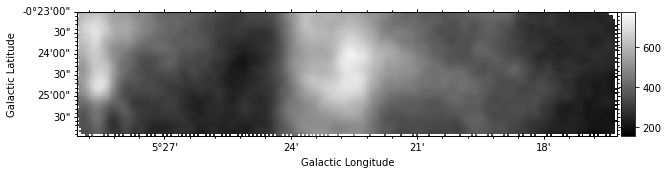

In [10]:
mom0_17 = cube_17.with_mask(mask_17).moment0()
mom0_17.quicklook()

/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


INFO: Auto-setting vmin to  2.775e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.586e+01 [aplpy.core]


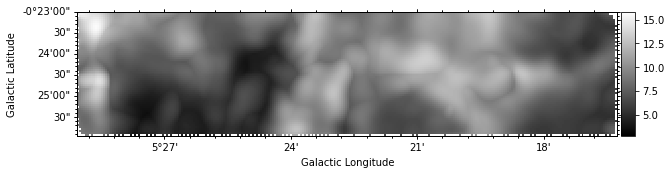

In [11]:
max_17 = cube_17.with_mask(mask_17).max(axis=0)
max_17.quicklook()

INFO: Auto-setting vmin to -6.390e+01 [aplpy.core]
INFO: Auto-setting vmax to  8.835e+02 [aplpy.core]


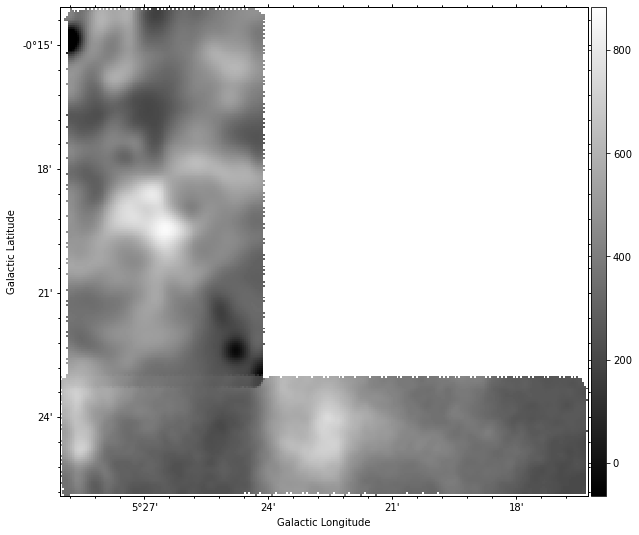

In [12]:
mom0_17_full = cube_17_full.with_mask(mask_17_full).moment0()
mom0_17_full.quicklook()

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


INFO: Auto-setting vmin to -5.712e+01 [aplpy.core]
INFO: Auto-setting vmax to  4.619e+02 [aplpy.core]


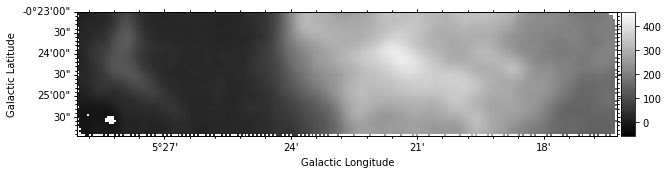

In [13]:
cube_17b = cube_17.spectral_slab(15*u.km / u.second, 75*u.km/u.second)
mask_17b = noise_mask_slab(cube_17, -100*u.km/u.second, -50 *u.km/u.second, 5, 15*u.km / u.second, 75*u.km/u.second)
mom0_17b = cube_17b.with_mask(mask_17b).moment0()
mom0_17b.quicklook()

/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


INFO: Auto-setting vmin to -1.109e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.459e+01 [aplpy.core]


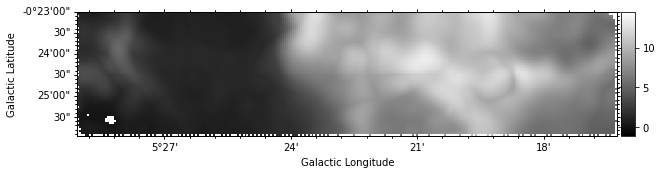

In [14]:
max_17b = cube_17b.with_mask(mask_17b).max(axis=0)
max_17b.quicklook()

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


INFO: Auto-setting vmin to -7.043e+01 [aplpy.core]
INFO: Auto-setting vmax to  4.586e+02 [aplpy.core]


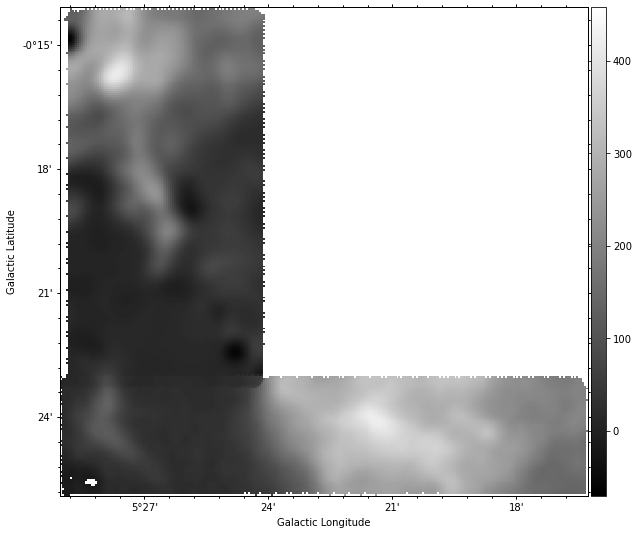

In [15]:
cube_17b_full = cube_17_full.spectral_slab(15*u.km / u.second, 75*u.km/u.second)
mask_17b_full = noise_mask_slab(cube_17_full, -100*u.km/u.second, -50 *u.km/u.second, 5, 15*u.km / u.second, 75*u.km/u.second)
momo0_17b_full = cube_17b_full.with_mask(mask_17b_full).moment0()
momo0_17b_full.quicklook()

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


INFO: Auto-setting vmin to -6.322e+01 [aplpy.core]
INFO: Auto-setting vmax to  7.066e+02 [aplpy.core]


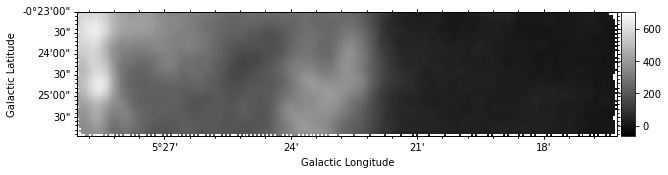

In [16]:
cube_17a = cube_17.spectral_slab(75*u.km / u.second, 200*u.km/u.second)
mask_17a = noise_mask_slab(cube_17, -100*u.km/u.second, -50 *u.km/u.second, 5, 75*u.km / u.second, 200*u.km/u.second)
mom0_17a = cube_17a.with_mask(mask_17a).moment0()
mom0_17a.quicklook()

/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


INFO: Auto-setting vmin to -1.336e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.636e+01 [aplpy.core]


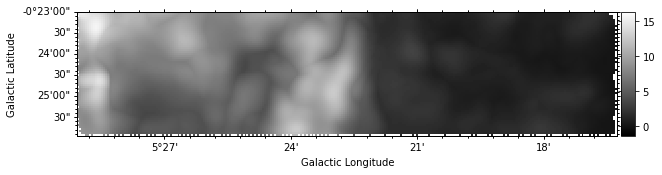

In [17]:
max_17a = cube_17a.with_mask(mask_17a).max(axis=0)
max_17a.quicklook()

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


INFO: Auto-setting vmin to -9.789e+01 [aplpy.core]
INFO: Auto-setting vmax to  7.148e+02 [aplpy.core]


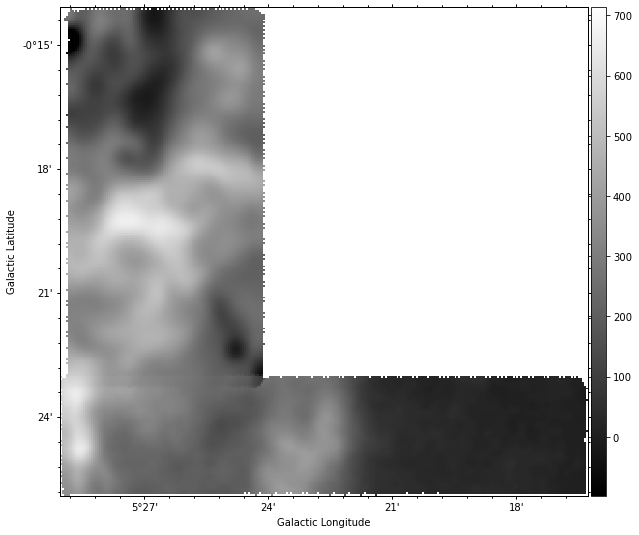

In [18]:
cube_17a_full = cube_17_full.spectral_slab(75*u.km / u.second, 200*u.km/u.second)
mask_17a_full = noise_mask_slab(cube_17_full, -100*u.km/u.second, -50 *u.km/u.second, 5, 75*u.km / u.second, 200*u.km/u.second)
mom0_17a_full = cube_17a_full.with_mask(mask_17a_full).moment0()
mom0_17a_full.quicklook()

INFO: Auto-setting vmin to -6.788e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.333e+00 [aplpy.core]


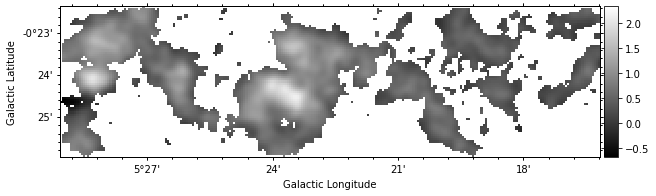

In [19]:
mom0_23 = cube_23.with_mask(mask_23).moment0()
mom0_23.quicklook()

INFO: Auto-setting vmin to -1.882e-04 [aplpy.core]
INFO: Auto-setting vmax to  1.113e-03 [aplpy.core]


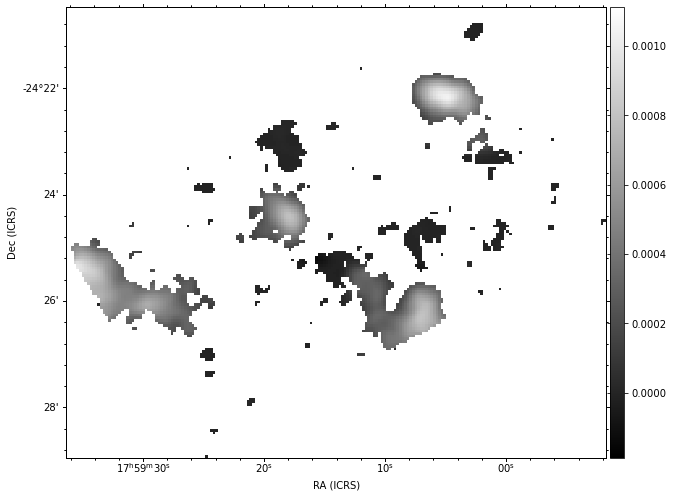

In [20]:
mom0_23b = cube_23b.with_mask(mask_23b).moment0()
mom0_23b.quicklook()

/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


INFO: Auto-setting vmin to  1.015e-02 [aplpy.core]
INFO: Auto-setting vmax to  1.090e-01 [aplpy.core]


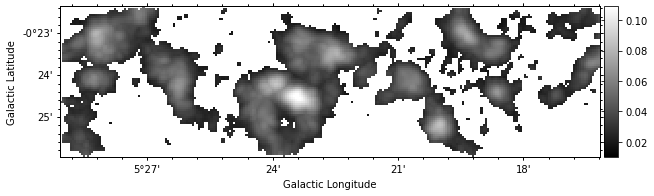

In [21]:
max_23 = cube_23.with_mask(mask_23).max(axis=0)
max_23.quicklook()

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


INFO: Auto-setting vmin to -3.101e-03 [aplpy.core]
INFO: Auto-setting vmax to  1.018e+00 [aplpy.core]


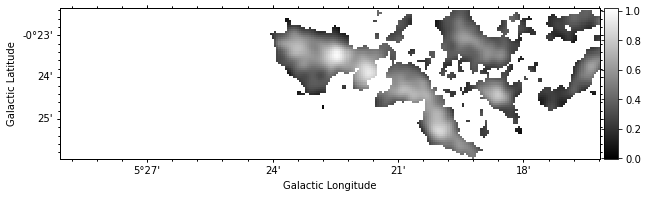

In [22]:
cube_23b = cube_23.spectral_slab(0*u.km / u.second, 75*u.km/u.second)
mask_23b = noise_mask_slab(cube_23, 50*u.km/u.second, 80 *u.km/u.second, 5, 0*u.km / u.second, 75*u.km/u.second)
mom0_23b = cube_23b.with_mask(mask_23b).moment0()
mom0_23b.quicklook()

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


INFO: Auto-setting vmin to -4.041e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.056e+00 [aplpy.core]


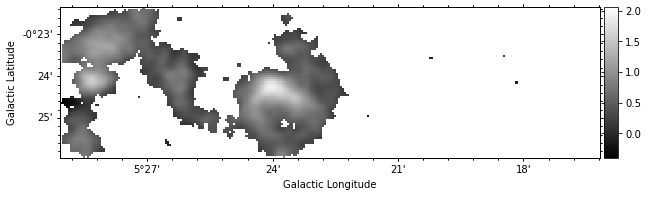

In [23]:
cube_23a = cube_23.spectral_slab(75*u.km / u.second, 200*u.km/u.second)
mask_23a = noise_mask_slab(cube_23, 50*u.km/u.second, 80 *u.km/u.second, 5, 75*u.km / u.second, 200*u.km/u.second)
mom0_23a = cube_23a.with_mask(mask_23a).moment0()
mom0_23a.quicklook()

INFO: Auto-setting vmin to -5.175e-01 [aplpy.core]
INFO: Auto-setting vmax to  6.419e+00 [aplpy.core]


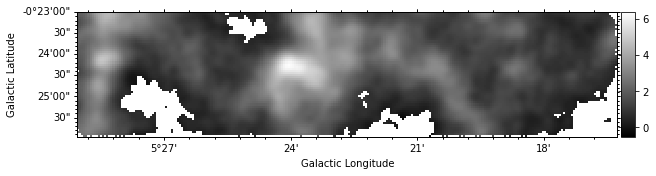

In [24]:
mom0_25 = cube_25.with_mask(mask_25).moment0()
mom0_25.quicklook()

INFO: Auto-setting vmin to -1.591e-03 [aplpy.core]
INFO: Auto-setting vmax to  4.314e-03 [aplpy.core]


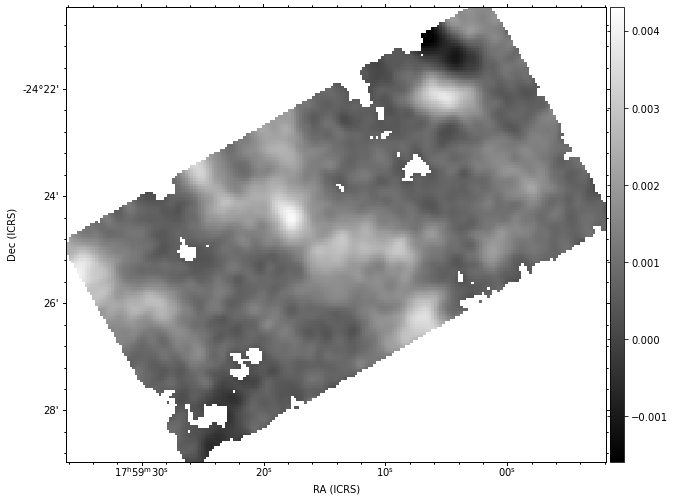

In [25]:
mom0_25b = cube_25b.with_mask(mask_25b).moment0()
mom0_25b.quicklook()

/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


INFO: Auto-setting vmin to -2.383e-03 [aplpy.core]
INFO: Auto-setting vmax to  2.779e-01 [aplpy.core]


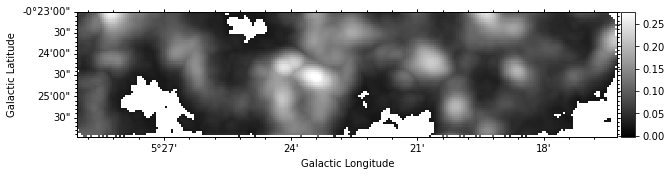

In [26]:
max_25 = cube_25.with_mask(mask_25).max(axis=0)
max_25.quicklook()

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


INFO: Auto-setting vmin to -1.669e-01 [aplpy.core]
INFO: Auto-setting vmax to  3.533e+00 [aplpy.core]


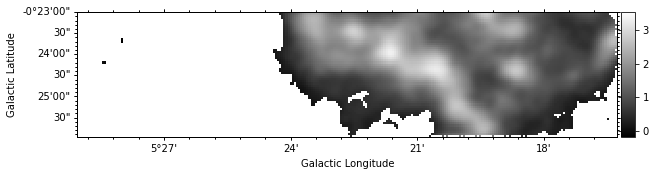

In [27]:
cube_25b = cube_25.spectral_slab(0*u.km / u.second, 75*u.km/u.second)
mask_25b = noise_mask_slab(cube_25, -100*u.km/u.second, -50*u.km/u.second, 5, 0*u.km / u.second, 75*u.km/u.second)
mom0_25b = cube_25b.with_mask(mask_25b).moment0()
mom0_25b.quicklook()

In [28]:
np.nanmax(mom0_25b)

<Projection 3.31167304 K km / s>

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


INFO: Auto-setting vmin to -4.119e-01 [aplpy.core]
INFO: Auto-setting vmax to  6.160e+00 [aplpy.core]


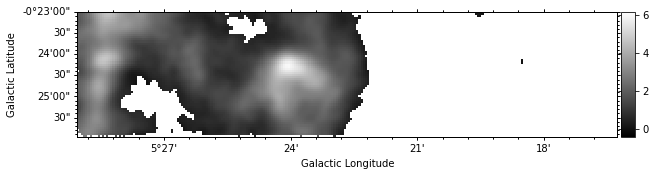

In [29]:
cube_25a = cube_25.spectral_slab(75*u.km / u.second, 200*u.km/u.second)
mask_25a = noise_mask_slab(cube_25, -100*u.km/u.second, -50*u.km/u.second, 5, 75*u.km / u.second, 200*u.km/u.second)
mom0_25a = cube_25a.with_mask(mask_25a).moment0()
mom0_25a.quicklook()

In [30]:
np.nanmax(mom0_25a)

<Projection 5.96338351 K km / s>

INFO: Auto-setting vmin to -2.802e-01 [aplpy.core]
INFO: Auto-setting vmax to  4.898e+00 [aplpy.core]


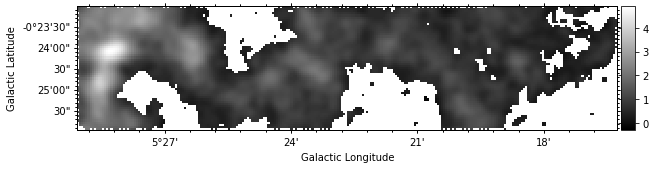

In [31]:
mom0_27 = cube_27.with_mask(mask_27).moment0()
mom0_27.quicklook()

/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


INFO: Auto-setting vmin to  4.253e-03 [aplpy.core]
INFO: Auto-setting vmax to  2.209e-01 [aplpy.core]


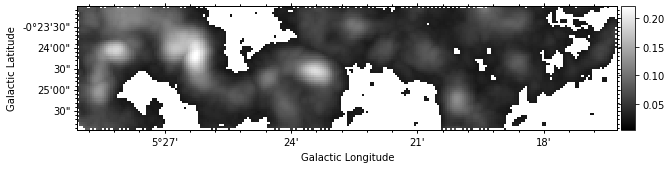

In [32]:
max_27 = cube_27.with_mask(mask_27).max(axis=0)
max_27.quicklook()

INFO: Auto-setting vmin to -7.387e-01 [aplpy.core]
INFO: Auto-setting vmax to  4.570e+00 [aplpy.core]
INFO: Auto-setting vmin to -7.459e-01 [aplpy.core]
INFO: Auto-setting vmax to  4.696e+00 [aplpy.core]


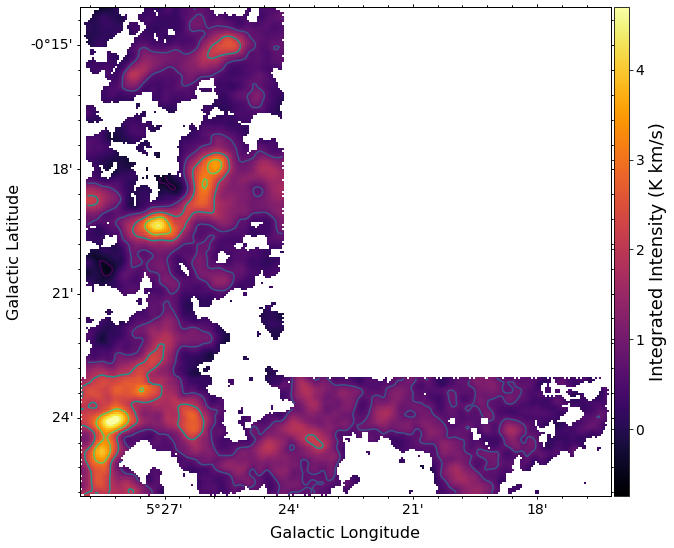

In [33]:
cube27_0_full = cube_27_full.with_mask(mask_27_full).moment0()
cube27_0_full.quicklook()
cube27_0_full.FITSFigure.show_colorscale(cmap='inferno')
cube27_0_full.FITSFigure.colorbar.set_axis_label_text('Integrated Intensity (K km/s)')
cube27_0_full.FITSFigure.show_contour(cube27_0_full.hdu)
cube27_0_full.FITSFigure.colorbar.set_axis_label_font(size=18)
cube27_0_full.FITSFigure.colorbar.set_font(size=14)
cube27_0_full.FITSFigure.axis_labels.set_font(size=16)
cube27_0_full.FITSFigure.tick_labels.set_font(size=14)

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


INFO: Auto-setting vmin to -5.848e-02 [aplpy.core]
INFO: Auto-setting vmax to  1.740e+00 [aplpy.core]


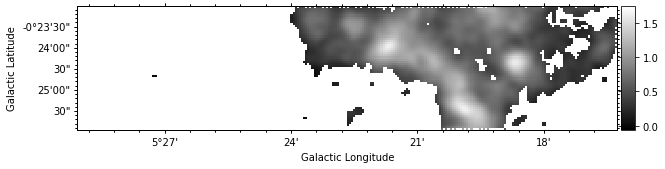

In [34]:
cube_27b = cube_27.spectral_slab(0*u.km / u.second, 75*u.km/u.second)
mask_27b = noise_mask_slab(cube_27, -100*u.km/u.second, -50*u.km/u.second, 5, 0*u.km / u.second, 75*u.km/u.second)
mom0_27b = cube_27b.with_mask(mask_27b).moment0()
mom0_27b.quicklook()

In [35]:
np.nanmax(mom0_27b)

<Projection 1.63359526 K km / s>

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


INFO: Auto-setting vmin to -2.615e-01 [aplpy.core]
INFO: Auto-setting vmax to  5.059e+00 [aplpy.core]


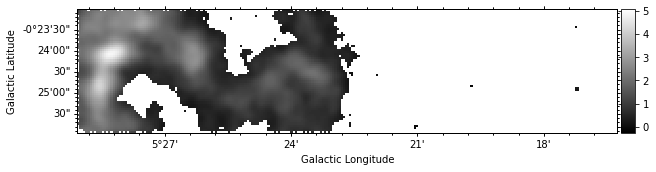

In [36]:
cube_27a = cube_27.spectral_slab(75*u.km / u.second, 200*u.km/u.second)
mask_27a = noise_mask_slab(cube_27, -100*u.km/u.second, -50*u.km/u.second, 5, 75*u.km / u.second, 200*u.km/u.second)
mom0_27a = cube_27a.with_mask(mask_27a).moment0()
mom0_27a.quicklook()

In [37]:
np.nanmax(mom0_27a)

<Projection 4.87508989 K km / s>

INFO: Auto-setting vmin to  3.846e+00 [aplpy.core]
INFO: Auto-setting vmax to  5.891e+01 [aplpy.core]


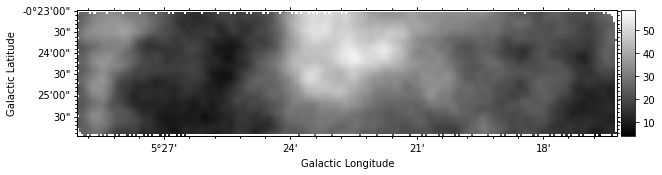

In [38]:
mom0_29 = cube_29.with_mask(mask_29).moment0()
mom0_29.quicklook()

/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


INFO: Auto-setting vmin to  9.536e-02 [aplpy.core]
INFO: Auto-setting vmax to  2.447e+00 [aplpy.core]


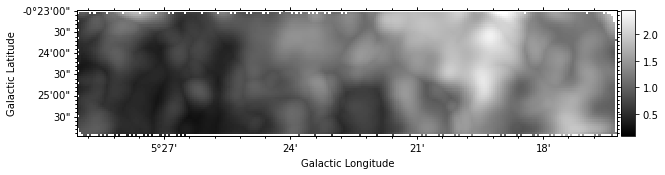

In [39]:
max_29 = cube_29.with_mask(mask_29).max(axis=0)
max_29.quicklook()

INFO: Auto-setting vmin to -5.307e+00 [aplpy.core]
INFO: Auto-setting vmax to  6.516e+01 [aplpy.core]


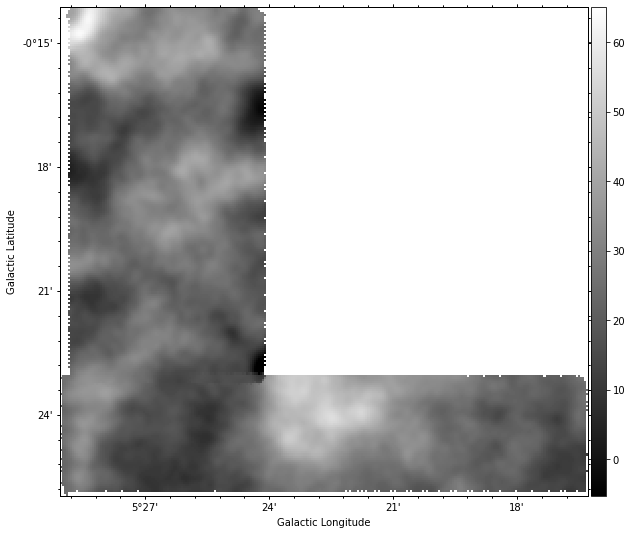

In [40]:
mom0_29_full = cube_29_full.with_mask(mask_29_full).moment0()
mom0_29_full.quicklook()

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


INFO: Auto-setting vmin to -4.353e+00 [aplpy.core]
INFO: Auto-setting vmax to  5.208e+01 [aplpy.core]


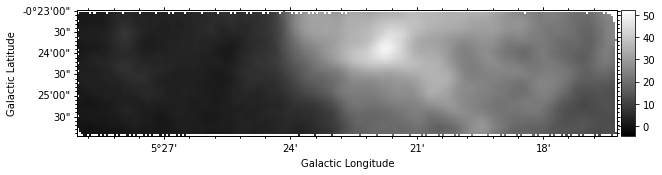

In [41]:
cube_29b = cube_29.spectral_slab(0*u.km / u.second, 75*u.km/u.second)
mask_29b = noise_mask_slab(cube_29, -100*u.km/u.second, -50*u.km/u.second, 5, 0*u.km / u.second, 75*u.km/u.second)
mom0_29b = cube_29b.with_mask(mask_29b).moment0()
mom0_29b.quicklook()

/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


INFO: Auto-setting vmin to -2.283e-02 [aplpy.core]
INFO: Auto-setting vmax to  2.492e+00 [aplpy.core]


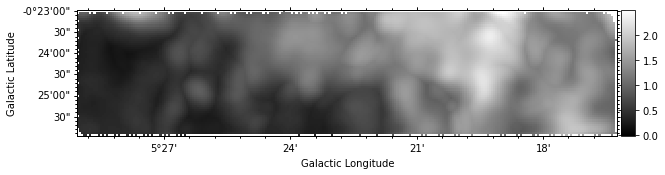

In [42]:
max_29b = cube_29b.with_mask(mask_29b).max(axis=0)
max_29b.quicklook()

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


INFO: Auto-setting vmin to -7.793e+00 [aplpy.core]
INFO: Auto-setting vmax to  4.988e+01 [aplpy.core]


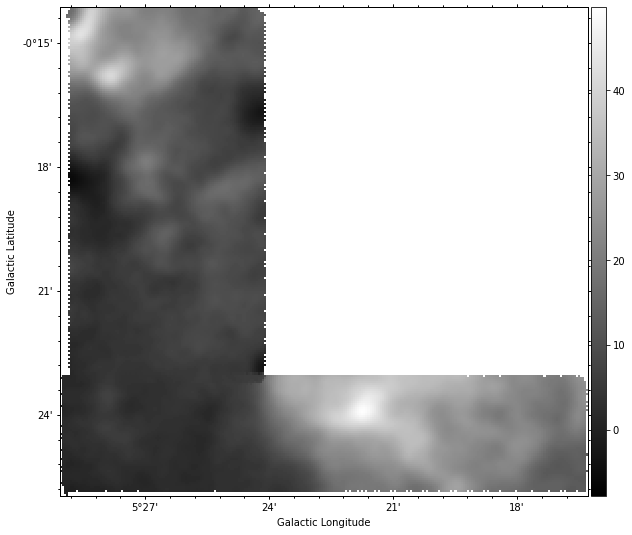

In [43]:
cube_29b_full = cube_29_full.spectral_slab(0*u.km / u.second, 75*u.km/u.second)
mask_29b_full = noise_mask_slab(cube_29_full, -100*u.km/u.second, -50*u.km/u.second, 5, 0*u.km / u.second, 75*u.km/u.second)
mom0_29b_full = cube_29b_full.with_mask(mask_29b_full).moment0()
mom0_29b_full.quicklook()

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


INFO: Auto-setting vmin to -5.172e+00 [aplpy.core]
INFO: Auto-setting vmax to  4.168e+01 [aplpy.core]


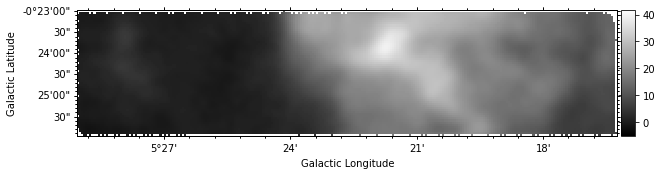

In [44]:
cube_29b_iso = cube_29.spectral_slab(15*u.km / u.second, 75*u.km/u.second)
mask_29b_iso = noise_mask_slab(cube_29, -100*u.km/u.second, -50*u.km/u.second, 5, 15*u.km / u.second, 75*u.km/u.second)
mom0_29b_iso = cube_29b_iso.with_mask(mask_29b).moment0()
mom0_29b_iso.quicklook()

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


INFO: Auto-setting vmin to -1.099e+01 [aplpy.core]
INFO: Auto-setting vmax to  4.397e+01 [aplpy.core]


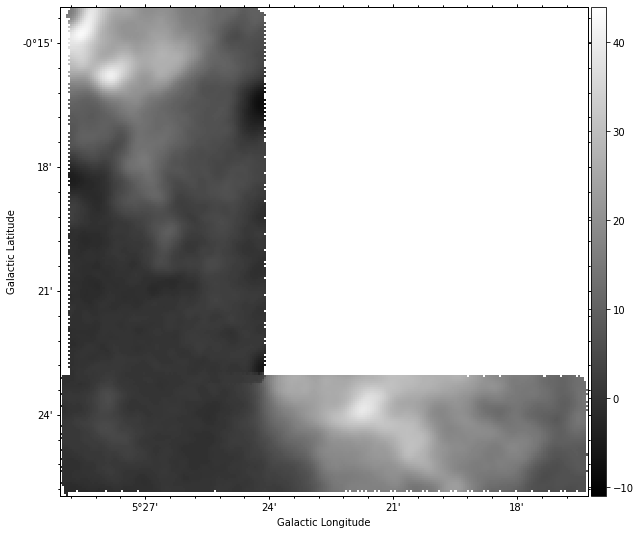

In [45]:
cube_29b_iso_full = cube_29_full.spectral_slab(15*u.km / u.second, 75*u.km/u.second)
mask_29b_iso_full = noise_mask_slab(cube_29_full, -100*u.km/u.second, -50*u.km/u.second, 5, 15*u.km / u.second, 75*u.km/u.second)
mom0_29b_iso_full = cube_29b_iso_full.with_mask(mask_29b_full).moment0()
mom0_29b_iso_full.quicklook()

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


INFO: Auto-setting vmin to -6.148e+00 [aplpy.core]
INFO: Auto-setting vmax to  3.682e+01 [aplpy.core]


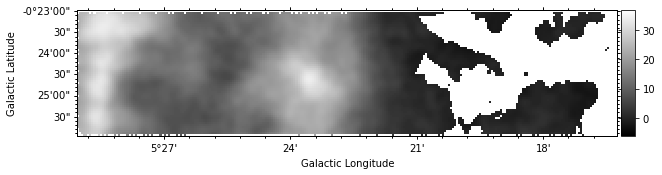

In [46]:
cube_29a = cube_29.spectral_slab(75*u.km / u.second, 200*u.km/u.second)
mask_29a = noise_mask_slab(cube_29, -100*u.km/u.second, -50*u.km/u.second, 5, 75*u.km / u.second, 200*u.km/u.second)
mom0_29a = cube_29a.with_mask(mask_29a).moment0()
mom0_29a.quicklook()

/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


INFO: Auto-setting vmin to -7.997e-02 [aplpy.core]
INFO: Auto-setting vmax to  1.512e+00 [aplpy.core]


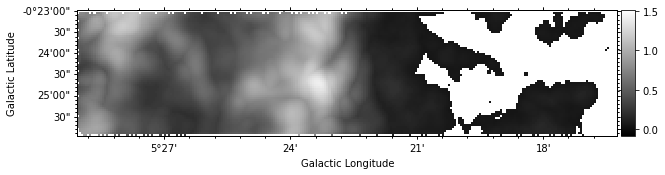

In [47]:
max_29a = cube_29a.with_mask(mask_29a).max(axis=0)
max_29a.quicklook()

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


INFO: Auto-setting vmin to -6.112e+00 [aplpy.core]
INFO: Auto-setting vmax to  3.634e+01 [aplpy.core]


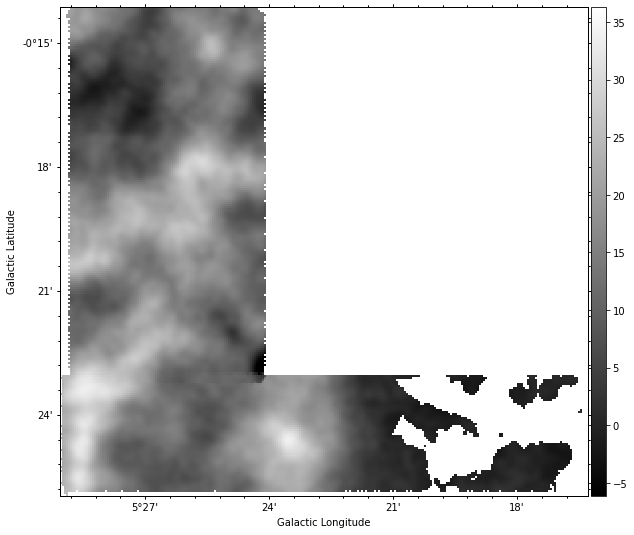

In [48]:
cube_29a_full = cube_29_full.spectral_slab(75*u.km / u.second, 200*u.km/u.second)
mask_29a_full = noise_mask_slab(cube_29_full, -100*u.km/u.second, -50*u.km/u.second, 5, 75*u.km / u.second, 200*u.km/u.second)
mom0_29a_full = cube_29a_full.with_mask(mask_29a_full).moment0()
mom0_29a_full.quicklook()

INFO: Auto-setting vmin to -8.025e-01 [aplpy.core]
INFO: Auto-setting vmax to  6.272e+00 [aplpy.core]


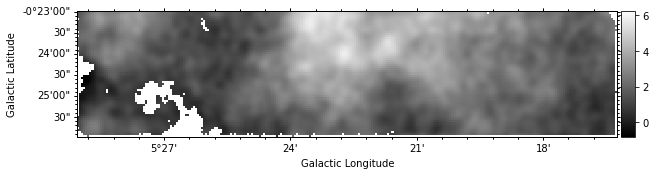

In [49]:
mom0_31 = cube_31.with_mask(mask_31).moment0()
mom0_31.quicklook()

/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


INFO: Auto-setting vmin to -2.042e-02 [aplpy.core]
INFO: Auto-setting vmax to  7.580e-01 [aplpy.core]


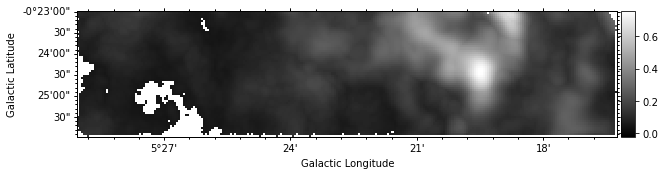

In [50]:
max_31 = cube_31.with_mask(mask_31).max(axis=0)
max_31.quicklook()

INFO: Auto-setting vmin to -1.146e+00 [aplpy.core]
INFO: Auto-setting vmax to  9.827e+00 [aplpy.core]


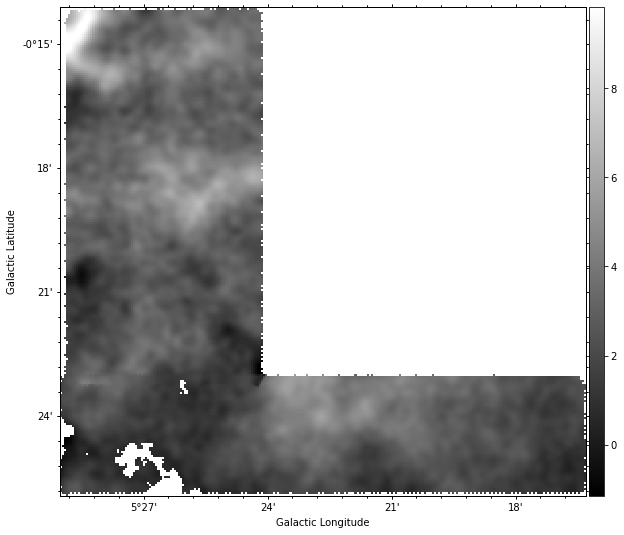

In [51]:
mom0_31_full = cube_31_full.with_mask(mask_31_full).moment0()
mom0_31_full.quicklook()

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


INFO: Auto-setting vmin to -7.402e-02 [aplpy.core]
INFO: Auto-setting vmax to  4.900e+00 [aplpy.core]


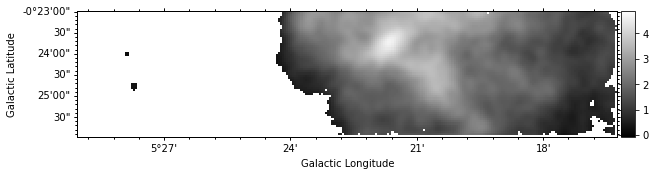

In [52]:
cube_31b = cube_31.spectral_slab(15*u.km / u.second, 75*u.km/u.second)
mask_31b = noise_mask_slab(cube_31, -100*u.km/u.second, -50*u.km/u.second, 5, 15*u.km / u.second, 75*u.km/u.second)
mom0_31b = cube_31b.with_mask(mask_31b).moment0()
mom0_31b.quicklook()

/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


INFO: Auto-setting vmin to  2.537e-02 [aplpy.core]
INFO: Auto-setting vmax to  2.366e-01 [aplpy.core]


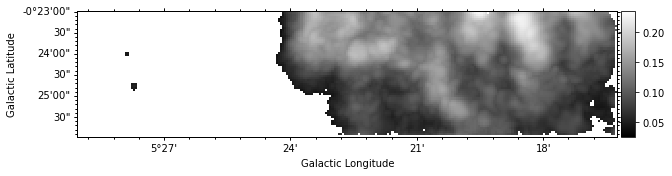

In [53]:
max_31b = cube_31b.with_mask(mask_31b).max(axis=0)
max_31b.quicklook()

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


INFO: Auto-setting vmin to -1.069e+00 [aplpy.core]
INFO: Auto-setting vmax to  9.274e+00 [aplpy.core]


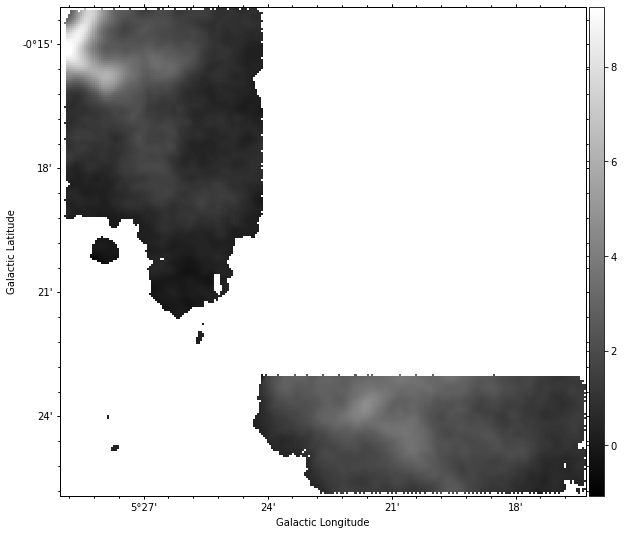

In [54]:
cube_31b_full = cube_31_full.spectral_slab(15*u.km / u.second, 75*u.km/u.second)
mask_31b_full = noise_mask_slab(cube_31_full, -100*u.km/u.second, -50*u.km/u.second, 5, 15*u.km / u.second, 75*u.km/u.second)
mom0_31b_full = cube_31b_full.with_mask(mask_31b_full).moment0()
mom0_31b_full.quicklook()

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


INFO: Auto-setting vmin to  4.086e-02 [aplpy.core]
INFO: Auto-setting vmax to  3.652e+00 [aplpy.core]


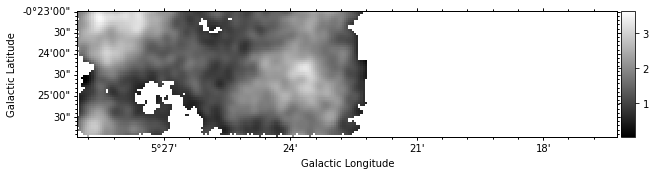

In [55]:
cube_31a = cube_31.spectral_slab(75*u.km / u.second, 200*u.km/u.second)
mask_31a = noise_mask_slab(cube_31, -100*u.km/u.second, -50*u.km/u.second, 5, 75*u.km / u.second, 200*u.km/u.second)
mom0_31a = cube_31a.with_mask(mask_31a).moment0()
mom0_31a.quicklook()

/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


INFO: Auto-setting vmin to  2.670e-02 [aplpy.core]
INFO: Auto-setting vmax to  2.165e-01 [aplpy.core]


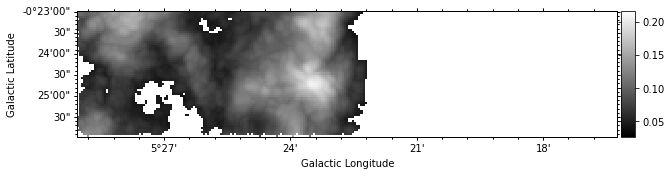

In [56]:
max_31a = cube_31a.with_mask(mask_31a).max(axis=0)
max_31a.quicklook()

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


INFO: Auto-setting vmin to -5.153e-01 [aplpy.core]
INFO: Auto-setting vmax to  4.426e+00 [aplpy.core]


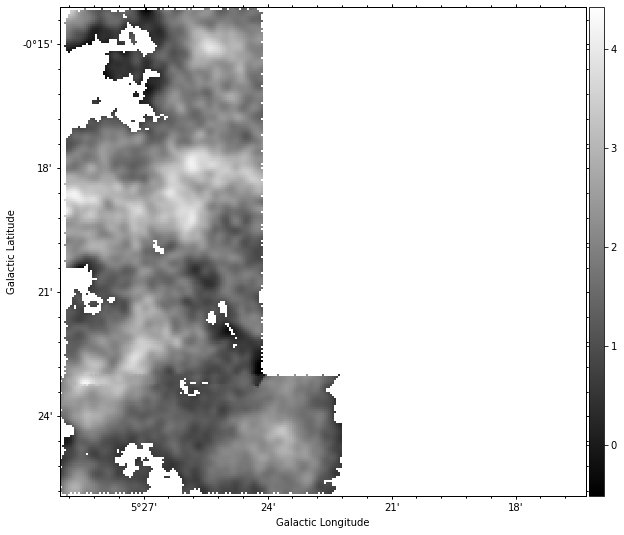

In [57]:
cube_31a_full = cube_31_full.spectral_slab(75*u.km / u.second, 200*u.km/u.second)
mask_31a_full = noise_mask_slab(cube_31_full, -100*u.km/u.second, -50*u.km/u.second, 5, 75*u.km / u.second, 200*u.km/u.second)
mom0_31a_full = cube_31a_full.with_mask(mask_31a_full).moment0()
mom0_31a_full.quicklook()

## Ratios

### $^{12}$CO / $^{13}$CO

INFO: Auto-setting vmin to  7.847e+00 [aplpy.core]
INFO: Auto-setting vmax to  3.370e+01 [aplpy.core]


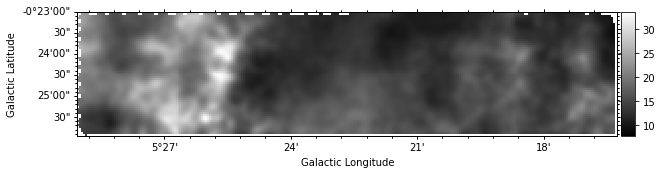

In [58]:
ratio_1729 = mom0_17 / mom0_29.reproject(mom0_17.header)
ratio_1729.quicklook()

INFO: Auto-setting vmin to  1.097e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.556e+01 [aplpy.core]


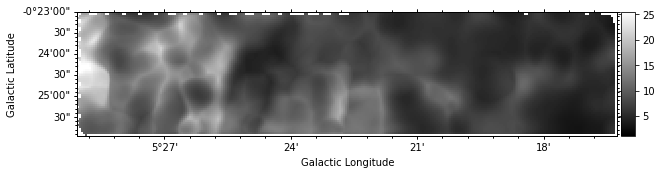

In [59]:
max_ratio_1729 = max_17 / max_29.reproject(max_17.header)
max_ratio_1729.quicklook()

In [60]:
#mom0_17_full = cube_17_full.with_mask(mask_17_full).spectral_slab(15*u.km/u.second, 200*u.km/u.second).moment0()
#mom0_29_full = cube_29_full.with_mask(mask_29_full).spectral_slab(15*u.km/u.second, 200*u.km/u.second).moment0()
#mom0_29_full = mom0_29_full.reproject(mom0_17_full.header)
#mom0_29_full = mom0_29_full.with_mask(mask_17_full).moment0()

INFO: Auto-setting vmin to  1.901e+00 [aplpy.core]
INFO: Auto-setting vmax to  4.316e+01 [aplpy.core]


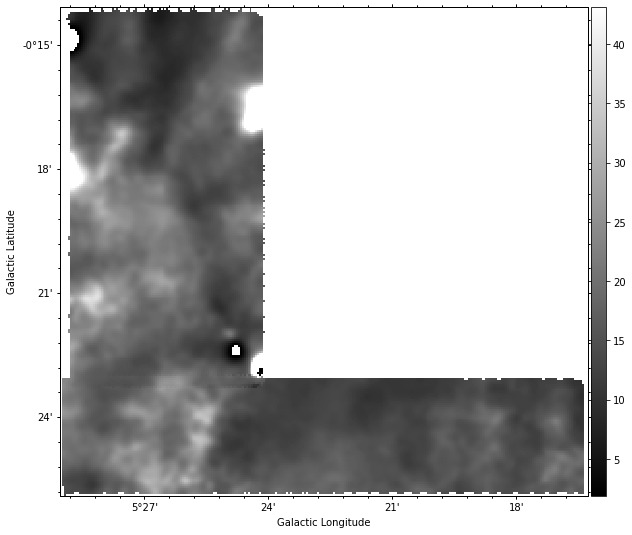

In [61]:
ratio_1729_full = mom0_17_full / mom0_29_full.reproject(mom0_17_full.header)
ratio_1729_full[ratio_1729_full<0] = np.nan
ratio_1729_full[ratio_1729_full>50] = np.nan
ratio_1729_full.quicklook()

In [62]:
#ratio_1729_full = cube_17_full.with_mask(mask_17_full).moment0() / cube_29_full.with_mask(mask_29_full).reproject(cube_17_full.header).with_mask(mask_17_full).moment0()
#ratio_1729_full.quicklook()

INFO: Auto-setting vmin to  7.896e+00 [aplpy.core]
INFO: Auto-setting vmax to  3.384e+01 [aplpy.core]


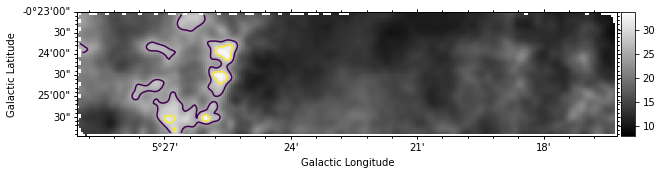

In [63]:
rat_1729 = ratio_1729*1.0
rat_1729.quicklook()
rat_1729.FITSFigure.show_contour(rat_1729.hdu, levels=[25,30])

INFO: Auto-setting vmin to -4.194e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.698e+02 [aplpy.core]


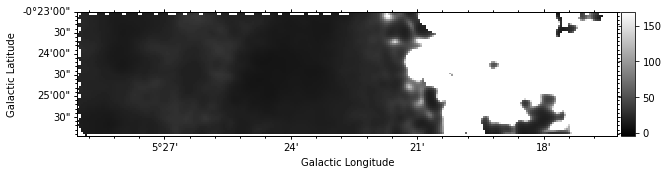

In [64]:
ratio_1729a = mom0_17a / mom0_29a.reproject(mom0_17a.header)
ratio_1729a[ratio_1729a<0] = np.nan
ratio_1729a[ratio_1729a>200] = np.nan

ratio_1729a.quicklook()

INFO: Auto-setting vmin to  6.330e+00 [aplpy.core]
INFO: Auto-setting vmax to  5.239e+01 [aplpy.core]


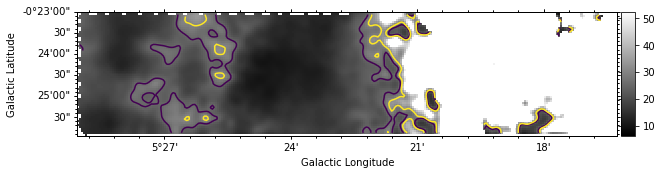

In [65]:
ratio_1729a[ratio_1729a>50] = np.nan
rat_1729a = ratio_1729a*1.0
rat_1729a.quicklook()
rat_1729a.FITSFigure.show_contour(rat_1729a.hdu, levels=[25,30])

INFO: Auto-setting vmin to -2.036e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.510e+01 [aplpy.core]


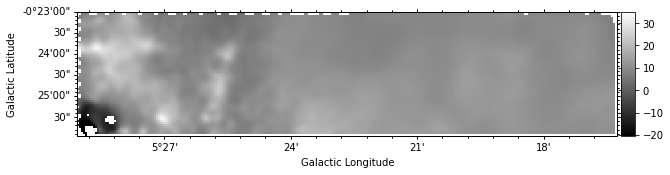

In [66]:
ratio_1729b = mom0_17b / mom0_29b.reproject(mom0_17b.header)
#cube_17b.with_mask(mask_17b).moment0() / cube_29b_iso.with_mask(mask_29b_iso).reproject(cube_17b.header).with_mask(mask_17b).moment0()
ratio_1729b.quicklook()

INFO: Auto-setting vmin to  1.296e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.890e+01 [aplpy.core]


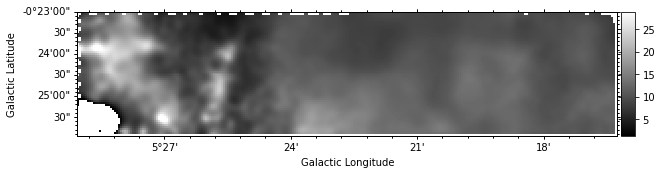

In [67]:
rat_1729b = ratio_1729b*1.0
rat_1729b[rat_1729b<0]=np.nan
rat_1729b[rat_1729b>60]=np.nan
rat_1729b.quicklook()

### $^{13}$CO / C$^{18}$O

INFO: Auto-setting vmin to -2.129e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.026e+02 [aplpy.core]


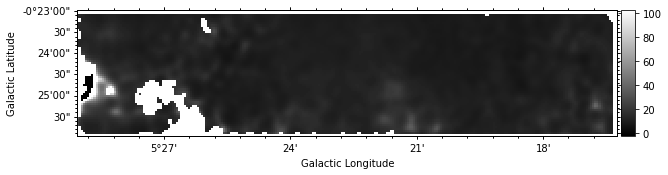

In [68]:
ratio_2931 = mom0_29 / mom0_31.reproject(mom0_29.header)
#cube_29.with_mask(mask_29).moment0() / cube_31.with_mask(mask_31).reproject(cube_29.header).with_mask(mask_29).moment0()
ratio_2931.quicklook()

INFO: Auto-setting vmin to  1.404e+00 [aplpy.core]
INFO: Auto-setting vmax to  5.911e+01 [aplpy.core]


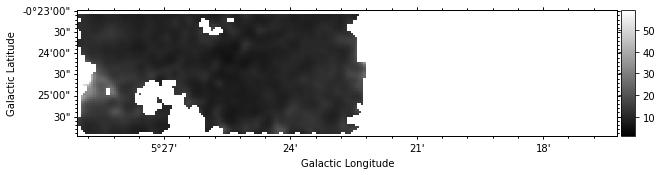

In [69]:
ratio_2931a = mom0_29a / mom0_31a.reproject(mom0_29a.header)
#cube_29a.with_mask(mask_29a).moment0() / cube_31a.with_mask(mask_31a).reproject(cube_29a.header).with_mask(mask_29a).moment0()
ratio_2931a.quicklook()

INFO: Auto-setting vmin to  7.789e+00 [aplpy.core]
INFO: Auto-setting vmax to  3.109e+01 [aplpy.core]


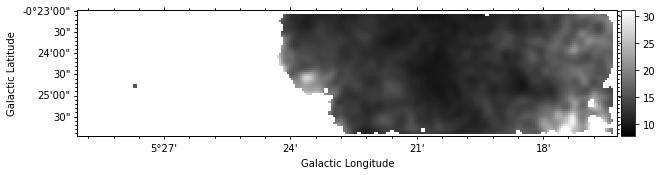

In [70]:
ratio_2931b = mom0_29b / mom0_31b.reproject(mom0_29b.header)
#cube_29b_iso.with_mask(mask_29b_iso).moment0() / cube_31b.with_mask(mask_31b).reproject(cube_29b_iso.header).with_mask(mask_29b_iso).moment0()
ratio_2931b.quicklook()

### $^{12}$CO / C$^{18}$O

INFO: Auto-setting vmin to  4.710e+01 [aplpy.core]
INFO: Auto-setting vmax to  5.205e+02 [aplpy.core]


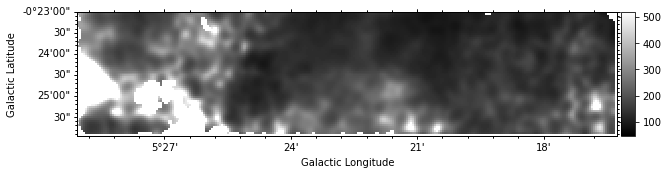

In [71]:
ratio_1731 = mom0_17 / mom0_31.reproject(mom0_17.header)
ratio_1731[ratio_1731<0] = np.nan
ratio_1731[ratio_1731>500] = np.nan
#cube_17.with_mask(mask_17).moment0() / cube_31.with_mask(mask_31).reproject(cube_17.header).with_mask(mask_17).moment0()
ratio_1731.quicklook()

In [72]:
#mom0_17_full = cube_17_full.with_mask(mask_17_full).spectral_slab(15*u.km/u.second, 200*u.km/u.second).moment0()
#mom0_31_full = cube_31_full.with_mask(mask_31_full).spectral_slab(15*u.km/u.second, 200*u.km/u.second).moment0()
#mom0_31_full = mom0_31_full.reproject(mom0_17_full.header)

INFO: Auto-setting vmin to -5.847e+00 [aplpy.core]
INFO: Auto-setting vmax to  4.305e+02 [aplpy.core]


array([ 37.42795046, 126.32997682, 215.23200317, 304.13402953,
       393.03605588])

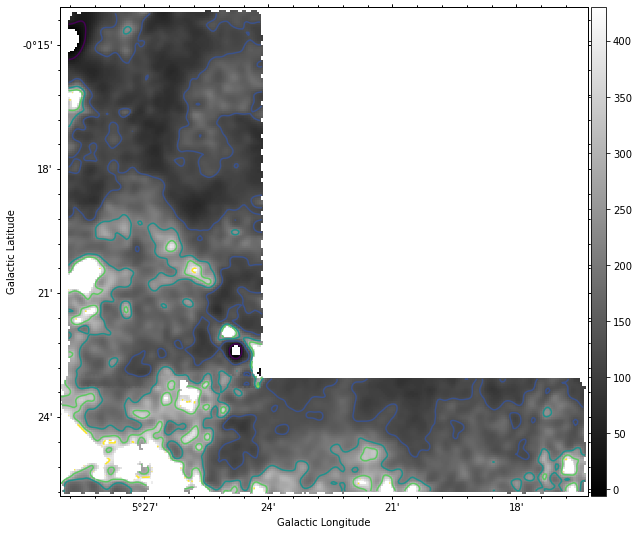

In [73]:
ratio_1731_full = mom0_17_full / mom0_31_full.reproject(mom0_17_full.header)
ratio_1731_full[ratio_1731_full<0] = np.nan
ratio_1731_full[ratio_1731_full>400] = np.nan
ratio_1731_full.quicklook()
ratio_1731_full.FITSFigure.show_contour(ratio_1731_full.hdu, returnlevels=True)

INFO: Auto-setting vmin to  3.528e+01 [aplpy.core]
INFO: Auto-setting vmax to  5.540e+02 [aplpy.core]


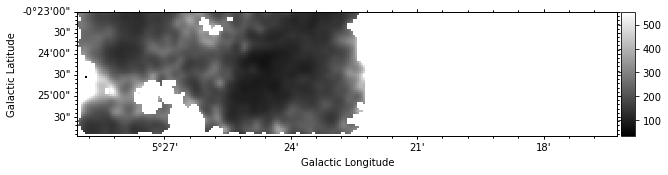

In [74]:
ratio_1731a = mom0_17a / mom0_31a.reproject(mom0_17a.header)
ratio_1731a[ratio_1731a>550] = np.nan
#cube_17a.with_mask(mask_17a).moment0() / cube_31a.with_mask(mask_31a).reproject(cube_17a.header).with_mask(mask_17a).moment0()
ratio_1731a.quicklook()

INFO: Auto-setting vmin to  6.024e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.645e+02 [aplpy.core]


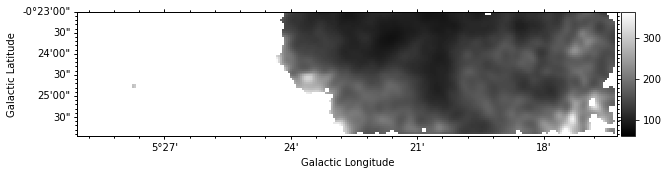

In [75]:
ratio_1731b = mom0_17b / mom0_31b.reproject(mom0_17b.header)
#cube_17b.with_mask(mask_17b).moment0() / cube_31b.with_mask(mask_31b).reproject(cube_17b.header).with_mask(mask_17b).moment0()
ratio_1731b.quicklook()

#### H$_2$CO (3$_{21}$-2$_{20}$) / H2CO (3$_{03}$-2$_{02}$)

INFO: Auto-setting vmin to -2.715e-01 [aplpy.core]
INFO: Auto-setting vmax to  7.564e-01 [aplpy.core]


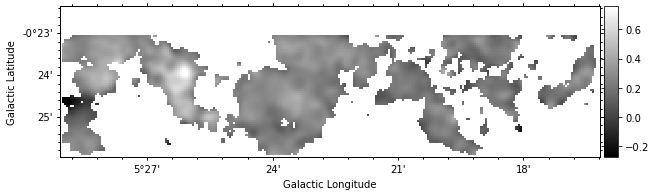

In [76]:
ratio_2325 = mom0_23 / mom0_25.reproject(mom0_23.header)
#cube_23.with_mask(mask_23).moment0() / cube_25.reproject(cube_23.header).with_mask(mask_23).moment0()
ratio_2325.quicklook()

INFO: Auto-setting vmin to  6.887e-02 [aplpy.core]
INFO: Auto-setting vmax to  3.763e-01 [aplpy.core]


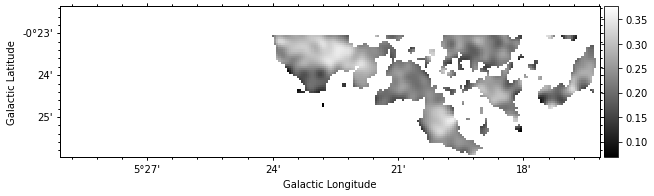

In [77]:
ratio_2325b = mom0_23b / mom0_25b.reproject(mom0_23b.header)
#cube_23.with_mask(mask_23).moment0() / cube_25.reproject(cube_23.header).with_mask(mask_23).moment0()
ratio_2325b.quicklook()

INFO: Auto-setting vmin to -1.771e-01 [aplpy.core]
INFO: Auto-setting vmax to  4.838e-01 [aplpy.core]


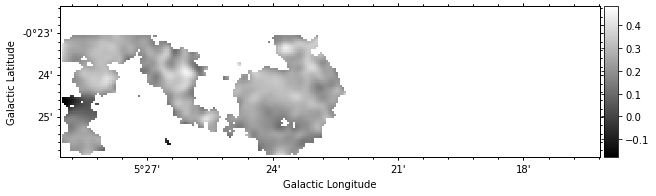

In [78]:
ratio_2325a = mom0_23a / mom0_25a.reproject(mom0_23a.header)
#cube_23a.with_mask(mask_23a).moment0() / cube_25a.reproject(cube_23a.header).with_mask(mask_23a).moment0()
ratio_2325a.quicklook()

INFO: Auto-setting vmin to  6.817e-02 [aplpy.core]
INFO: Auto-setting vmax to  3.807e-01 [aplpy.core]


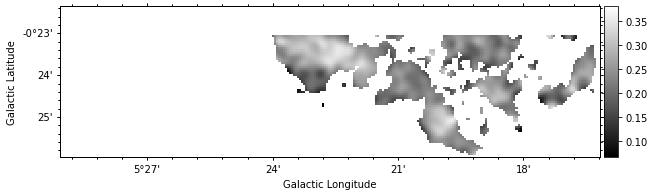

In [79]:
ratio_2325b = mom0_23b / mom0_25b.reproject(mom0_23b.header)
#cube_23b.with_mask(mask_23b).moment0() / cube_25b.reproject(cube_23b.header).with_mask(mask_23b).moment0()
ratio_2325b.quicklook()

#### H$_2$CO / $^{13}$CO

INFO: Auto-setting vmin to -1.051e-02 [aplpy.core]
INFO: Auto-setting vmax to  1.771e-01 [aplpy.core]


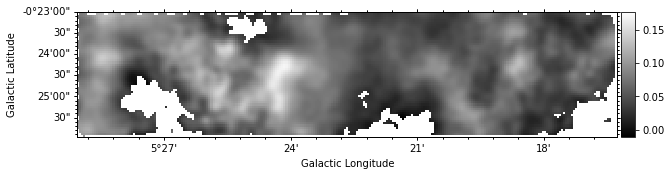

In [80]:
ratio_2529 = mom0_25 / mom0_29.reproject(mom0_25.header)
#cube_25.with_mask(mask_25).moment0() / cube_29.reproject(cube_25.header).with_mask(mask_25).moment0()
ratio_2529.quicklook()

INFO: Auto-setting vmin to  4.246e-03 [aplpy.core]
INFO: Auto-setting vmax to  1.136e-01 [aplpy.core]


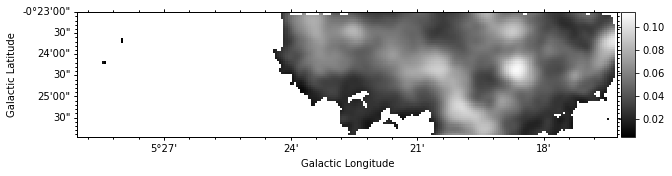

In [81]:
ratio_2529b = mom0_25b / mom0_29b.reproject(mom0_25b.header)
#cube_25b.with_mask(mask_25b).moment0() / cube_29b.reproject(cube_25b.header).with_mask(mask_25b).moment0()
ratio_2529b.quicklook()

INFO: Auto-setting vmin to -3.846e-03 [aplpy.core]
INFO: Auto-setting vmax to  2.425e-01 [aplpy.core]


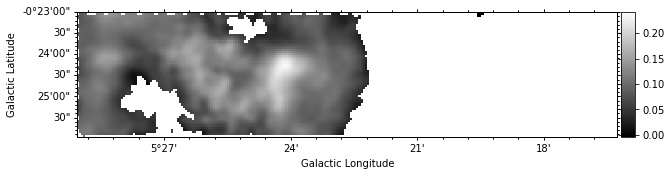

In [82]:
ratio_2529a = mom0_25a / mom0_29a.reproject(mom0_25a.header)
#cube_25a.with_mask(mask_25a).moment0() / cube_29a.reproject(cube_25a.header).with_mask(mask_25a).moment0()
ratio_2529a.quicklook()

#### SiO / $^{13}$CO

INFO: Auto-setting vmin to -9.698e-03 [aplpy.core]
INFO: Auto-setting vmax to  1.671e-01 [aplpy.core]


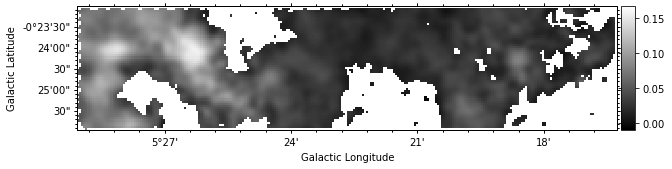

In [83]:
ratio_2729 = mom0_27 / mom0_29.reproject(mom0_27.header)
#cube_27.with_mask(mask_27).moment0() / cube_29.reproject(cube_27.header).with_mask(mask_27).moment0()
ratio_2729.quicklook()

INFO: Auto-setting vmin to -7.668e-03 [aplpy.core]
INFO: Auto-setting vmax to  2.113e-01 [aplpy.core]


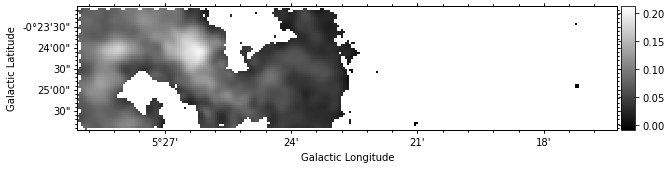

In [84]:
ratio_2729a = mom0_27a / mom0_29a.reproject(mom0_27a.header)
#cube_27a.with_mask(mask_27a).moment0() / cube_29a.reproject(cube_27a.header).with_mask(mask_27a).moment0()
ratio_2729a.quicklook()

INFO: Auto-setting vmin to -2.478e-05 [aplpy.core]
INFO: Auto-setting vmax to  6.929e-02 [aplpy.core]


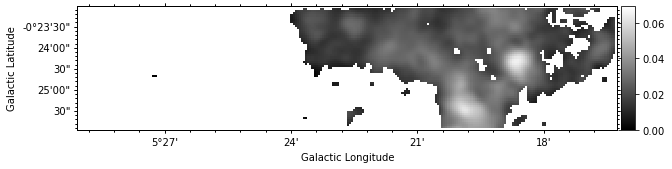

In [85]:
ratio_2729b = mom0_27b / mom0_29b.reproject(mom0_27b.header)
#cube_27b.with_mask(mask_27b).moment0() / cube_29b.reproject(cube_27b.header).with_mask(mask_27b).moment0()
ratio_2729b.quicklook()

#### SiO / H$_2$CO

INFO: Auto-setting vmin to -1.481e-01 [aplpy.core]
INFO: Auto-setting vmax to  3.405e+00 [aplpy.core]


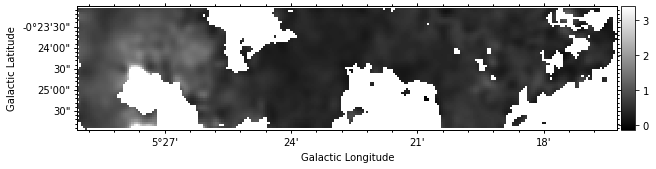

In [86]:
ratio_2725 = mom0_27 / mom0_25.reproject(mom0_27.header)
#cube_27.with_mask(mask_27).moment0() / cube_25.with_mask(mask_25).reproject(cube_27.header).with_mask(mask_27).moment0()
ratio_2725.quicklook()

INFO: Auto-setting vmin to  9.017e-02 [aplpy.core]
INFO: Auto-setting vmax to  8.284e-01 [aplpy.core]


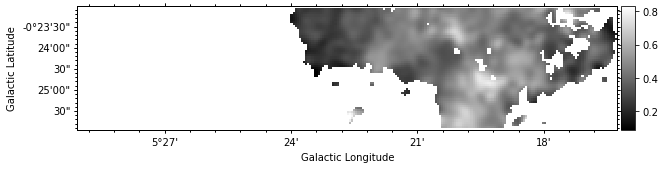

In [87]:
ratio_2725b = mom0_27b / mom0_25b.reproject(mom0_27b.header)
#cube_27b.with_mask(mask_27b).moment0() / cube_25b.with_mask(mask_25b).reproject(cube_27b.header).with_mask(mask_27b).moment0()
ratio_2725b.quicklook()

INFO: Auto-setting vmin to -7.389e-02 [aplpy.core]
INFO: Auto-setting vmax to  2.712e+00 [aplpy.core]


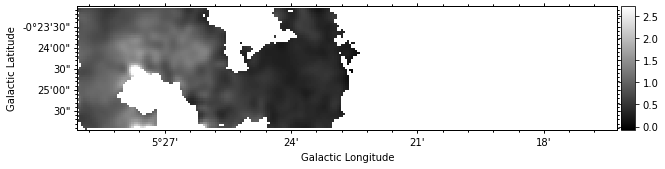

In [88]:
ratio_2725a = mom0_27a / mom0_25a.reproject(mom0_27a.header)
#cube_27a.with_mask(mask_27a).moment0() / cube_25a.with_mask(mask_25a).reproject(cube_27a.header).with_mask(mask_27a).moment0()
#ratio_2725a[ratio_2725a>1] = np.nan
ratio_2725a.quicklook()

## Temperatures

INFO: Auto-setting vmin to  7.938e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.962e+02 [aplpy.core]


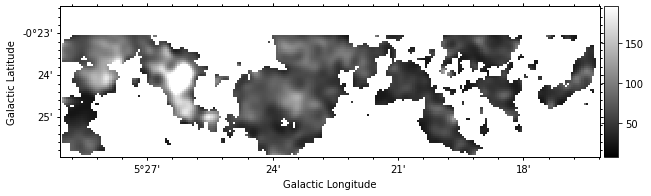

In [89]:
temp_all = t_kin(ratio_2325)
temp_all[temp_all>200] = np.nan
temp_all.quicklook()

INFO: Auto-setting vmin to  2.244e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.033e+02 [aplpy.core]
INFO: Auto-setting vmin to  2.206e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.047e+02 [aplpy.core]


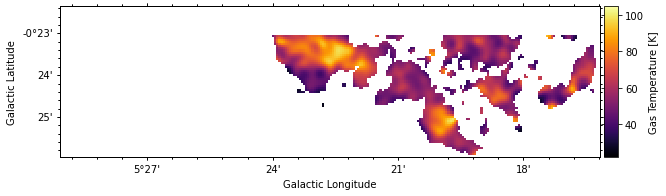

In [90]:
temp_allb = t_kin(ratio_2325b)#.reproject()
temp_allb[temp_allb>200] = np.nan
temp_allb.quicklook()
temp_allb.FITSFigure.colorbar.set_axis_label_text('Gas Temperature [K]')
temp_allb.FITSFigure.show_colorscale(cmap='inferno')
#temp_allb.FITSFigure.savefig('/orange/adamginsburg/cmz/g5/code/plots/tempplot.pdf')

INFO: Auto-setting vmin to  1.266e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.440e+02 [aplpy.core]


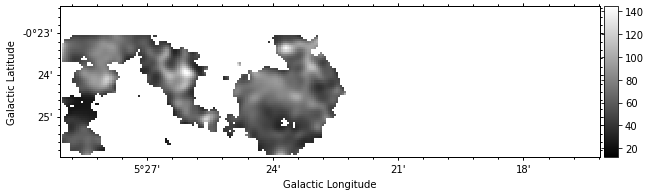

In [91]:
temp_a = t_kin(ratio_2325a)
temp_a[temp_a>200] = np.nan
temp_a.quicklook()

INFO: Auto-setting vmin to  2.512e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.047e+02 [aplpy.core]


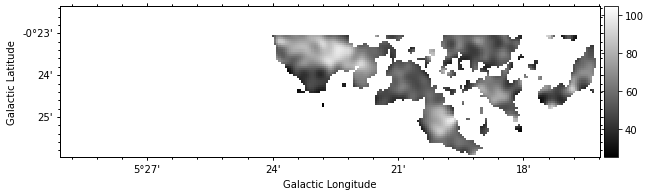

In [92]:
temp_b = t_kin(ratio_2325b)
temp_b[temp_b>200] = np.nan
temp_b.quicklook()

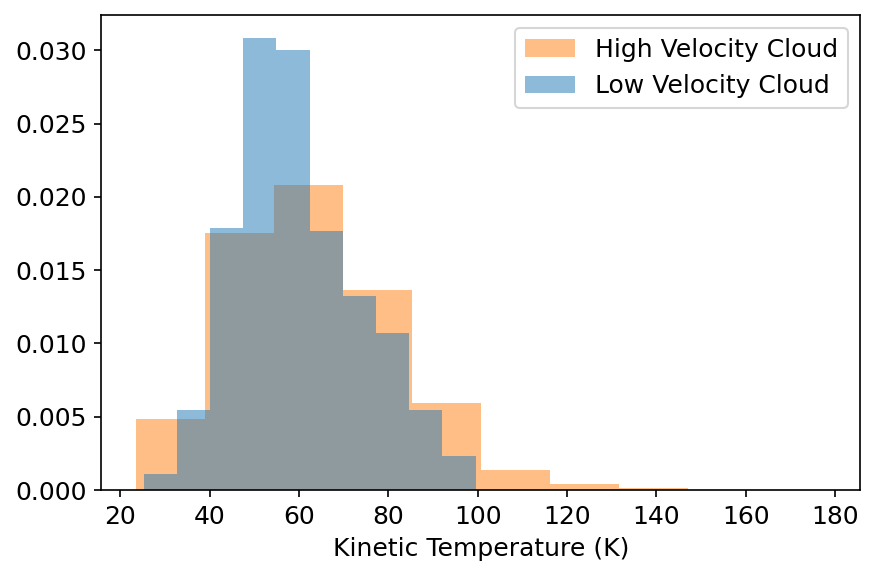

In [93]:
with quantity_support():
    #np.isfinite(mass_map)
    plt.figure(figsize=(6,4),dpi=150)
    plt.rcParams.update({'font.size': 12})

    counts_a, bins_a = np.histogram(temp_a[np.isfinite(temp_a)])
    plt.hist(bins_a[:-1], bins_a, alpha=0.5, label='High Velocity Cloud', color='tab:orange', weights=counts_a, density=True)
    counts_b, bins_b = np.histogram(temp_b[np.isfinite(temp_b)])
    plt.hist(bins_b[:-1], bins_b, alpha=0.5, label='Low Velocity Cloud', color='tab:blue', weights=counts_b, density=True)
    #maskedb = mean_tempb_h2co_masked[np.isfinite(mean_tempb_h2co_masked)]
    #maskeda = mean_tempa_h2co_masked[np.isfinite(mean_tempa_h2co_masked)]
    #abin = plt.hist(maskeda, alpha=0.5, label='Low-Velocity Cloud')
    #bbin = plt.hist(maskedb, alpha=0.5, label='High-Velocity Cloud')
    plt.legend()
    plt.xlabel('Kinetic Temperature (K)')
    #plt.ylabel('# of Pixels')
    plt.tight_layout()
    #plt.yscale('log')

    plt.savefig('/orange/adamginsburg/cmz/g5/code/plots/temphisst-update.pdf')

In [94]:
np.nanmean(temp_a)

<Projection 63.11549258>

In [95]:
np.nanstd(temp_a)

<Projection 18.78185999>

In [96]:
np.nanmean(temp_b)

<Projection 59.88052914>

In [97]:
np.nanstd(temp_b)

<Projection 13.78458939>

In [98]:
ks_2samp(temp_a.flatten(), temp_b.flatten())

KstestResult(statistic=0.047579211544494404, pvalue=2.982134201991303e-19)

## Mean Ratios

In [99]:
x_2325 = get_x(ratio_2325)

<__array_function__ internals>:180: RuntimeWarning: Mean of empty slice
<__array_function__ internals>:180: RuntimeWarning: Degrees of freedom <= 0 for slice.


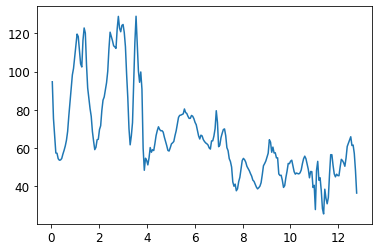

In [100]:
mean_ratio_temp = np.nanmean(temp_all, axis=0)
std_ratio_temp = np.nanstd(temp_all, axis=0)

plt.plot(x_2325, mean_ratio_temp)

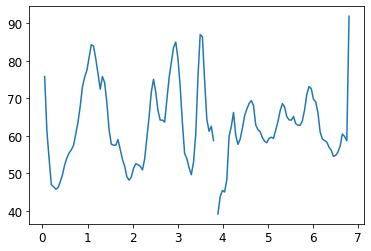

In [101]:
mean_ratio_temp_a = np.nanmean(temp_a, axis=0)
std_ratio_temp_a = np.nanstd(temp_a, axis=0)
mean_ratio_temp_a[139] = np.nan
plt.plot(x_2325, mean_ratio_temp_a)

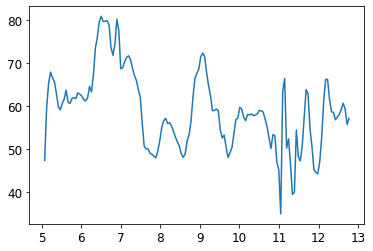

In [102]:
mean_ratio_temp_b = np.nanmean(temp_b, axis=0)
std_ratio_temp_b = np.nanstd(temp_b, axis=0)
plt.plot(x_2325, mean_ratio_temp_b)

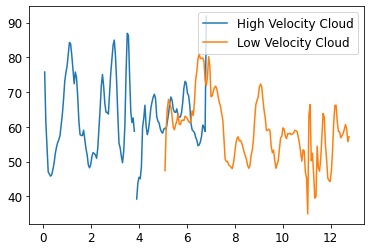

In [103]:
#plt.plot(x_2325, mean_ratio_temp, label='Both')
plt.plot(x_2325, mean_ratio_temp_a, label='High Velocity Cloud')
plt.plot(x_2325, mean_ratio_temp_b, label='Low Velocity Cloud')
pl.legend()

#### H$_2$CO / $^{13}$CO

In [104]:
x_2529 = get_x(ratio_2529)

<__array_function__ internals>:180: RuntimeWarning: Mean of empty slice
<__array_function__ internals>:180: RuntimeWarning: Degrees of freedom <= 0 for slice.


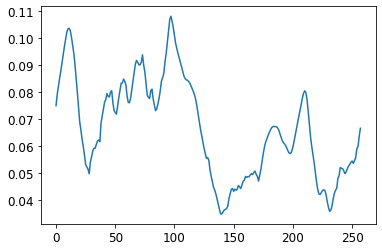

In [105]:
mean_ratio_2529 = np.nanmean(ratio_2529, axis=0)
std_ratio_2529 = np.nanstd(ratio_2529, axis=0)

plt.plot(mean_ratio_2529)


In [106]:
np.nanmean(ratio_2529a)/np.nanmean(ratio_2529b)

<Projection 1.96203628>

In [107]:
np.nanmean(ratio_2729a)/np.nanmean(ratio_2729b)

<Projection 2.91509231>

In [108]:
np.nanmean(ratio_2725a)/np.nanmean(ratio_2725b)

<Projection 1.70055488>

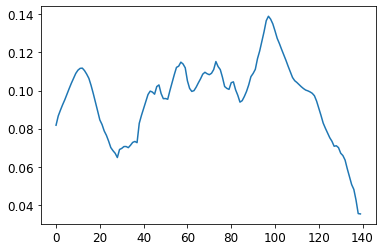

In [109]:
mean_ratio_2529a = np.nanmean(ratio_2529a, axis=0)
std_ratio_2529a = np.nanstd(ratio_2529a, axis=0)
mean_ratio_2529a[160:] = np.nan
plt.plot(mean_ratio_2529a)

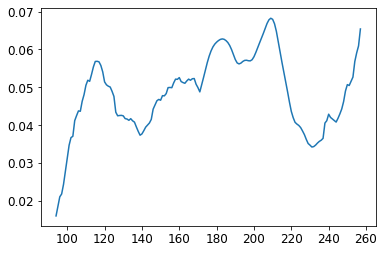

In [110]:
mean_ratio_2529b = np.nanmean(ratio_2529b, axis=0)
std_ratio_2529b = np.nanstd(ratio_2529b, axis=0)
mean_ratio_2529b[:50] = np.nan
plt.plot(mean_ratio_2529b)

#### SiO / $^{13}$CO

In [111]:
x_2729 = get_x(ratio_2729)

<__array_function__ internals>:180: RuntimeWarning: Mean of empty slice
<__array_function__ internals>:180: RuntimeWarning: Degrees of freedom <= 0 for slice.


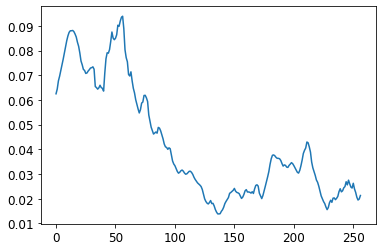

In [112]:
mean_ratio_2729 = np.nanmean(ratio_2729, axis=0)
std_ratio_2729 = np.nanstd(ratio_2729, axis=0)
plt.plot(mean_ratio_2729)

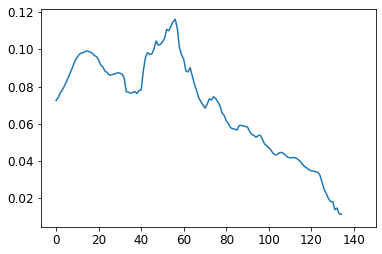

In [113]:
mean_ratio_2729a = np.nanmean(ratio_2729a, axis=0)
std_ratio_2729a = np.nanstd(ratio_2729a, axis=0)
mean_ratio_2729a[150:] = np.nan
plt.plot(mean_ratio_2729a)

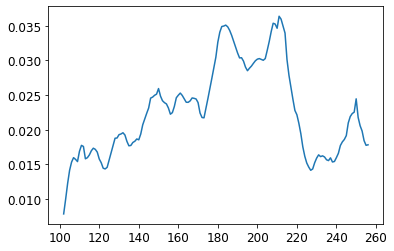

In [114]:
mean_ratio_2729b = np.nanmean(ratio_2729b, axis=0)
std_ratio_2729b = np.nanstd(ratio_2729b, axis=0)
mean_ratio_2729b[:75] = np.nan
plt.plot(mean_ratio_2729b)

#### SiO / H$_2$CO

In [115]:
x_2725 = get_x(ratio_2725)

In [116]:
#plt.plot(x_2725, np.nanmean(ratio_2725, axis=0))
#plt.errorbar(x_2725, np.nanmean(ratio_2725, axis=0), yerr=np.sqrt(np.nansum(np.power(mean_ratio_2725 - ratio_2725, 2), axis=0)), alpha=0.2, color='tab:blue')
#plt.ylim(bottom=-3, top=5)

INFO: Auto-setting vmin to -1.725e-03 [aplpy.core]
INFO: Auto-setting vmax to  2.623e-02 [aplpy.core]


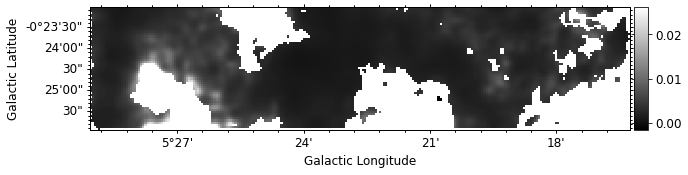

In [117]:
# delz = z * np.sqrt((delx/x)^2 + (dely/y)^2)
# -100*u.km/u.second, -50 *u.km/u.second
del_27 = cube_27.with_spectral_unit(u.km/u.s, velocity_convention='radio').spectral_slab(-100*u.km/u.second, -50 *u.km/u.second).moment0()#.std(axis=0)
del_25 = cube_25.with_spectral_unit(u.km/u.s, velocity_convention='radio').spectral_slab(-100*u.km/u.second, -50 *u.km/u.second).moment0()#.std(axis=0)
error_ratio_2725 = ratio_2725 * np.sqrt((np.nanmean(del_25)/mom0_25.reproject(mom0_27.header))**2 
                                        + (np.nanmean(del_27)/mom0_27)**2)
# noise = cube.with_spectral_unit(u.km/u.s, velocity_convention='radio').spectral_slab(vmin, vmax).std(axis=0)
#np.mean()
error_ratio_2725[error_ratio_2725>np.nanpercentile(error_ratio_2725, 99.5)]=np.nan
error_ratio_2725.quicklook()

In [118]:
np.nanpercentile(error_ratio_2725, 99.)

<Projection 0.01454517>

In [119]:
np.nanmean(del_27)

<Projection 0.00293694 K km / s>

In [120]:
#np.nanpercentile(tem_ratio_2725, 99.9)

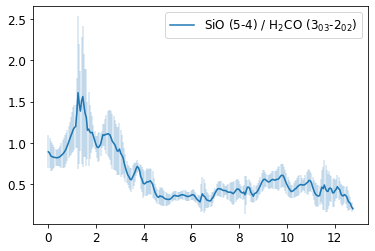

In [121]:
tem_ratio_2725 = ratio_2725*1.0
tem_ratio_2725[error_ratio_2725>np.nanpercentile(error_ratio_2725, 99.5)]=np.nan
tem_ratio_2725[tem_ratio_2725>np.nanpercentile(tem_ratio_2725, 99.9)] =np.nan
mean_ratio_2725 = np.nanmean(tem_ratio_2725, axis=0)
std_ratio_2725 = np.nanstd(tem_ratio_2725, axis=0)
plt.plot(x_2725, mean_ratio_2725, label='SiO (5-4) / H$_2$CO (3$_{03}$-2$_{02}$)')
plt.errorbar(x_2725, mean_ratio_2725, yerr=std_ratio_2725, color='tab:blue', alpha=0.2)
plt.legend()

In [122]:
ratio_error_final = np.sqrt(np.nansum(np.power(error_ratio_2725, 2), axis=0)/np.sum(np.isfinite(error_ratio_2725), axis=0))

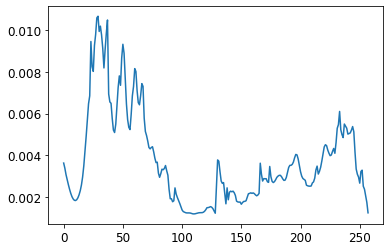

In [123]:
plt.plot(ratio_error_final)

<ErrorbarContainer object of 3 artists>

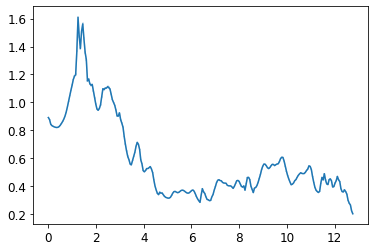

In [124]:
tes_ratio_2725 = mean_ratio_2725#np.nanmean(ratio_2725, axis=0)#[ratio_error_final<5]
#tes_ratio_2725[ratio_error_final>0.5] = np.nan
plt.plot(x_2725, tes_ratio_2725)
plt.errorbar(x_2725, tes_ratio_2725, 
             yerr=ratio_error_final,#np.sqrt(np.nansum(np.power(error_ratio_2725, 2), axis=0)/np.sum(np.isfinite(error_ratio_2725), axis=0)),
             alpha = 0.2, color='tab:blue')
#plt.ylim(bottom=0, top=)
#plt.xlim(left=4, right=6)

<__array_function__ internals>:180: RuntimeWarning: Mean of empty slice
<__array_function__ internals>:180: RuntimeWarning: Degrees of freedom <= 0 for slice.


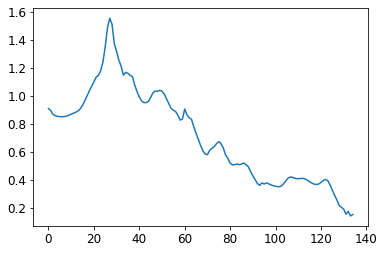

In [125]:
mean_ratio_2725a = np.nanmean(ratio_2725a, axis=0)
std_ratio_2725a = np.nanstd(ratio_2725a, axis=0)
plt.plot(mean_ratio_2725a)

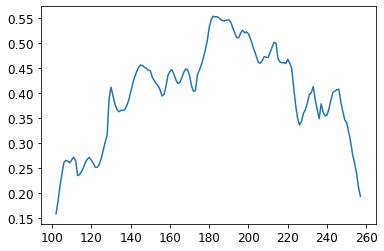

In [126]:
mean_ratio_2725b = np.nanmean(ratio_2725b, axis=0)
std_ratio_2725b = np.nanstd(ratio_2725b, axis=0)
plt.plot(mean_ratio_2725b)

## Fancy Plotting

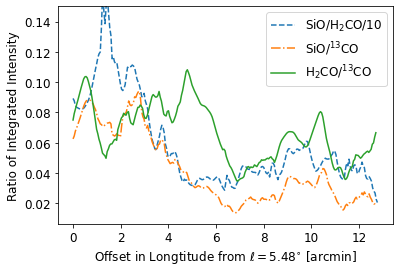

In [127]:
plt.plot(x_2725, mean_ratio_2725/10, '--', label='SiO/H$_2$CO/10')
plt.plot(x_2729, mean_ratio_2729, '-.', label='SiO/$^{13}$CO')
plt.plot(x_2529, mean_ratio_2529, '-', label='H$_2$CO/$^{13}$CO')

plt.ylim(top=0.15)

plt.xlabel("Offset in Longtitude from $\ell=5.48^{\circ}$ [arcmin]")
plt.ylabel('Ratio of Integrated Intensity')
plt.legend()

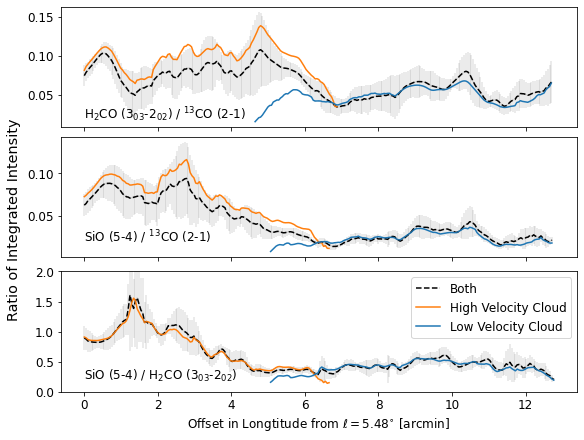

In [128]:
fig, axs = plt.subplots(3, sharex=True, gridspec_kw={'hspace': 0}, constrained_layout=True)
axs[0].plot(x_2529, mean_ratio_2529, color='k', linestyle='--')
axs[0].errorbar(x_2529, mean_ratio_2529, yerr=std_ratio_2529, alpha=0.1, color='k')
axs[0].plot(x_2529, mean_ratio_2529a, color='tab:orange')
axs[0].plot(x_2529, mean_ratio_2529b, color='tab:blue')
axs[0].text(0, 0.02, 'H$_2$CO (3$_{03}$-2$_{02}$) / $^{13}$CO (2-1)')

axs[1].plot(x_2729, mean_ratio_2729, color='k', linestyle='--')
axs[1].errorbar(x_2729, mean_ratio_2729, yerr=std_ratio_2729, alpha=0.1, color='k')
axs[1].plot(x_2729, mean_ratio_2729a, color='tab:orange')
axs[1].plot(x_2729, mean_ratio_2729b, color='tab:blue')
axs[1].text(0, 0.02, 'SiO (5-4) / $^{13}$CO (2-1)')

axs[2].plot(x_2725, mean_ratio_2725, label='Both', color='k', linestyle='--')
axs[2].errorbar(x_2725, mean_ratio_2725, yerr=std_ratio_2725, alpha=0.1, color='k')
axs[2].plot(x_2725, mean_ratio_2725a, label='High Velocity Cloud', color='tab:orange')
axs[2].plot(x_2725, mean_ratio_2725b, label='Low Velocity Cloud', color='tab:blue')
axs[2].set_ylim(top=2, bottom=0)
axs[2].legend()
axs[2].text(0, 0.2, 'SiO (5-4) / H$_2$CO (3$_{03}$-2$_{02}$)')

fig.set_figheight(6)
fig.set_figwidth(8)
fig.supylabel('Ratio of Integrated Intensity')
plt.xlabel("Offset in Longtitude from $\ell=5.48^{\circ}$ [arcmin]")

plt.savefig('/orange/adamginsburg/cmz/g5/code/plots/lineratios.pdf')

Text(0.5, 1.0, 'H$_2$CO/$^{13}$CO')

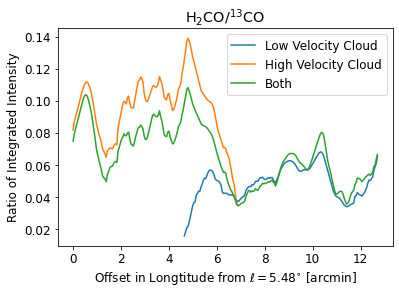

In [129]:
plt.plot(x_2529, mean_ratio_2529b, label='Low Velocity Cloud')
plt.plot(x_2529, mean_ratio_2529a, label='High Velocity Cloud')
plt.plot(x_2529, mean_ratio_2529, label='Both')
plt.xlabel("Offset in Longtitude from $\ell=5.48^{\circ}$ [arcmin]")
plt.ylabel('Ratio of Integrated Intensity')
plt.legend()
plt.title('H$_2$CO/$^{13}$CO')

Text(0.5, 1.0, 'SiO/$^{13}$CO')

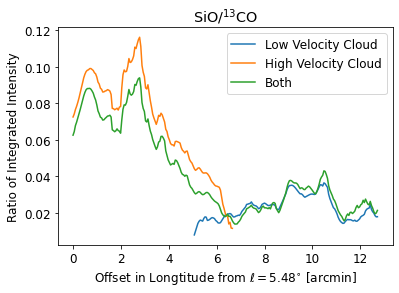

In [130]:
plt.plot(x_2729, mean_ratio_2729b, label='Low Velocity Cloud')
plt.plot(x_2729, mean_ratio_2729a, label='High Velocity Cloud')
plt.plot(x_2729, mean_ratio_2729, label='Both')
plt.xlabel("Offset in Longtitude from $\ell=5.48^{\circ}$ [arcmin]")
plt.ylabel('Ratio of Integrated Intensity')
plt.legend()
plt.title('SiO/$^{13}$CO')

(0.06818257371794717, 1.6)

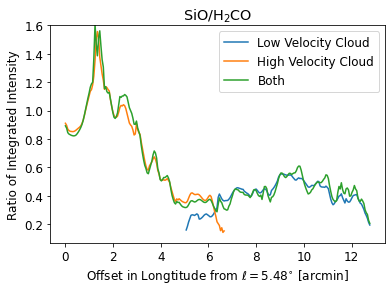

In [131]:
plt.plot(x_2725, mean_ratio_2725b, label='Low Velocity Cloud')
plt.plot(x_2725, mean_ratio_2725a, label='High Velocity Cloud')
plt.plot(x_2725, mean_ratio_2725, label='Both')
plt.xlabel("Offset in Longtitude from $\ell=5.48^{\circ}$ [arcmin]")
plt.ylabel('Ratio of Integrated Intensity')
plt.title('SiO/H$_2$CO')
plt.legend()
plt.ylim(top=1.6)

## Isotopologue Ratios

#### 12CO / 13CO

In [132]:
x_1729 = get_x(ratio_1729)

<__array_function__ internals>:180: RuntimeWarning: Mean of empty slice
<__array_function__ internals>:180: RuntimeWarning: Degrees of freedom <= 0 for slice.


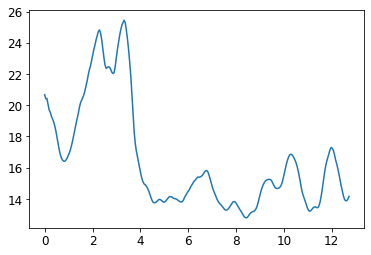

In [133]:
mean_ratio_1729 = np.nanmean(ratio_1729, axis=0)
std_ratio_1729 = np.nanstd(ratio_1729, axis=0)
mean_ratio_1729[std_ratio_1729>5] = np.nan
plt.plot(x_1729, mean_ratio_1729)

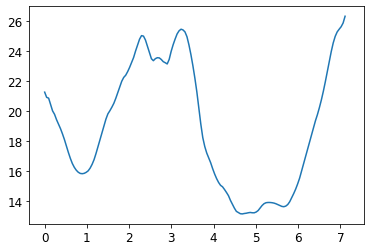

In [134]:
mean_ratio_1729a = np.nanmean(ratio_1729a, axis=0)
std_ratio_1729a = np.nanstd(ratio_1729a, axis=0)
mean_ratio_1729a[std_ratio_1729a>5] = np.nan
mean_ratio_1729a[155:] = np.nan
plt.plot(x_1729, mean_ratio_1729a)

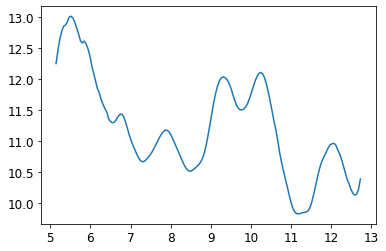

In [135]:
mean_ratio_1729b = np.nanmean(ratio_1729b, axis=0)
std_ratio_1729b = np.nanstd(ratio_1729b, axis=0)
mean_ratio_1729b[std_ratio_1729b>5] = np.nan
mean_ratio_1729b[:110]=np.nan
plt.plot(x_1729, mean_ratio_1729b)

#### 13CO / C18O

In [136]:
x_2931 = get_x(ratio_2931)

<__array_function__ internals>:180: RuntimeWarning: Mean of empty slice
<__array_function__ internals>:180: RuntimeWarning: Degrees of freedom <= 0 for slice.


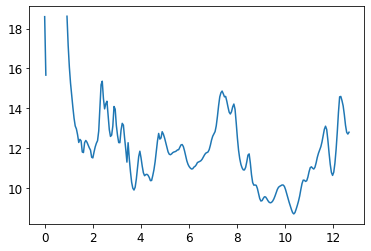

In [137]:
mean_ratio_2931 = np.nanmean(ratio_2931, axis=0)
std_ratio_2931 = np.nanstd(ratio_2931, axis=0)
mean_ratio_2931[std_ratio_2931>10] = np.nan
plt.plot(x_2931, mean_ratio_2931)

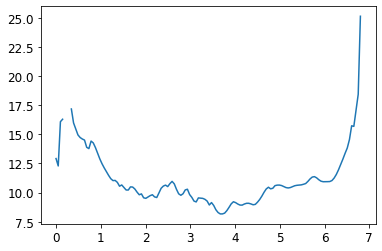

In [138]:
mean_ratio_2931a = np.nanmean(ratio_2931a, axis=0)
std_ratio_2931a = np.nanstd(ratio_2931a, axis=0)
mean_ratio_2931a[std_ratio_2931a>10] = np.nan
plt.plot(x_2931, mean_ratio_2931a)

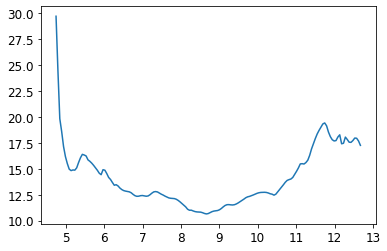

In [139]:
mean_ratio_2931b = np.nanmean(ratio_2931b, axis=0)
std_ratio_2931b = np.nanstd(ratio_2931b, axis=0)
mean_ratio_2931b[std_ratio_2931b>10] = np.nan
mean_ratio_2931b[:50] = np.nan
plt.plot(x_2931, mean_ratio_2931b)

#### 12CO / C18O

In [140]:
x_1731 = get_x(ratio_1731)

<__array_function__ internals>:180: RuntimeWarning: Mean of empty slice
<__array_function__ internals>:180: RuntimeWarning: Degrees of freedom <= 0 for slice.


<ErrorbarContainer object of 3 artists>

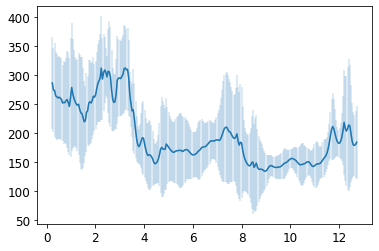

In [141]:
mean_ratio_1731 = np.nanmean(ratio_1731, axis=0)
std_ratio_1731 = np.nanstd(ratio_1731, axis=0)
mean_ratio_1731[std_ratio_1731>150] = np.nan
mean_ratio_1731[:5] = np.nan
plt.plot(x_1731, mean_ratio_1731)
plt.errorbar(x_1731, mean_ratio_1731, yerr=std_ratio_1731, alpha=0.2, color='tab:blue')
#plt.ylim(bottom=0, top=500)

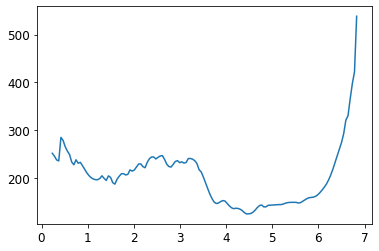

In [142]:
mean_ratio_1731a = np.nanmean(ratio_1731a, axis=0)
std_ratio_1731a = np.nanstd(ratio_1731a, axis=0)
mean_ratio_1731a[std_ratio_1731a>150] = np.nan
mean_ratio_1731a[:5] = np.nan
plt.plot(x_1731, mean_ratio_1731a)
#plt.errorbar(x_1731, mean_ratio_1731a, yerr=std_ratio_1731a, alpha=0.2, color='tab:blue')
#plt.ylim(bottom=0, top=500)

(0.0, 500.0)

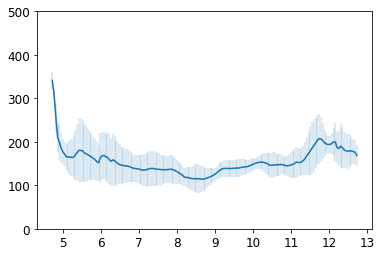

In [143]:
mean_ratio_1731b = np.nanmean(ratio_1731b, axis=0)
std_ratio_1731b = np.nanstd(ratio_1731b, axis=0)
#mean_ratio_1731b[std_ratio_1731b>10] = np.nan
mean_ratio_1731b[:50] = np.nan
plt.plot(x_1731, mean_ratio_1731b)
plt.errorbar(x_1731, mean_ratio_1731b, yerr=std_ratio_1731b, alpha=0.2, color='tab:blue')
plt.ylim(bottom=0, top=500)

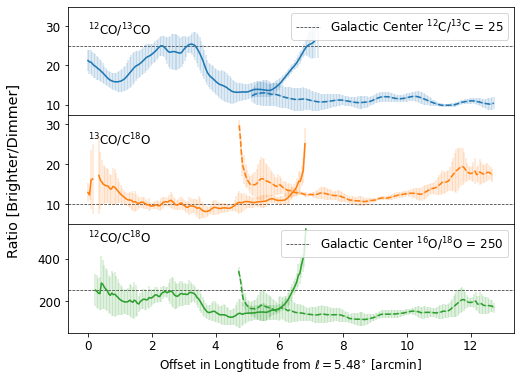

In [144]:
#plt.figure(figsize=(8,6),dpi=150)
#plt.rcParams.update({'font.size': 12})

fig, axs = plt.subplots(3, sharex=True, gridspec_kw={'hspace': 0})#, constrained_layout=True)

axs[0].errorbar(x_1729, mean_ratio_1729a, std_ratio_1729a, alpha = 0.2, color = 'tab:blue')
axs[0].errorbar(x_1729, mean_ratio_1729b, std_ratio_1729b, alpha = 0.2, color = 'tab:blue')
axs[1].errorbar(x_2931, mean_ratio_2931a, std_ratio_2931a, alpha = 0.2, color = 'tab:orange')
axs[1].errorbar(x_2931, mean_ratio_2931b, std_ratio_2931b, alpha = 0.2, color = 'tab:orange')
axs[2].errorbar(x_1731, mean_ratio_1731a, std_ratio_1731a, alpha = 0.2, color = 'tab:green')
axs[2].errorbar(x_1731, mean_ratio_1731b, std_ratio_1731b, alpha = 0.2, color = 'tab:green')

axs[0].plot(x_1729, mean_ratio_1729a, color = 'tab:blue')#, label='$^{12}$CO/$^{13}$CO')
axs[0].plot(x_1729, mean_ratio_1729b, color = 'tab:blue', linestyle='dashed')
axs[1].plot(x_2931, mean_ratio_2931a, color = 'tab:orange')#, label='$^{13}$CO/C$^{18}$O')
axs[1].plot(x_2931, mean_ratio_2931b, color = 'tab:orange', linestyle='dashed')
axs[2].plot(x_1731, mean_ratio_1731a, color = 'tab:green')#, label='$^{12}$CO/C$^{18}$O')
axs[2].plot(x_1731, mean_ratio_1731b, color = 'tab:green', linestyle='dashed')

#for ax in axs.flat:
#    ax.legend()
#    ax.label_outer()  
    
def inverse(x):
    """Vectorized 1/x, treating x==0 manually"""
    x = np.array(x).astype(float)
    near_zero = np.isclose(x, 0)
    x[near_zero] = np.inf
    x[~near_zero] = 1 / x[~near_zero]
    return x

axs[0].axhline(25, color='black', linestyle='dashed', alpha=0.8, zorder=-5, linewidth=0.75, label='Galactic Center $^{12}$C/$^{13}$C = 25') # 12/13
#axs[0].axhline(30, color='purple', linestyle='dashed', alpha=0.75, zorder=-5, linewidth=0.75)
#axs[0].axhline(40, color='red', linestyle='dashed', alpha=0.75, zorder=-5, linewidth=0.75)
axs[0].text(0, 28, '$^{12}$CO/$^{13}$CO')
axs[0].legend(loc='upper right')
axs[0].set_ylim(top=35)
#axs[0].axhline(77, color='red', linestyle='dotted') 

axs[1].axhline(250/25, color='black', linestyle='dashed', alpha=0.8, zorder=-5, linewidth=0.75) # 18/13
#axs[1].axhline(400/30, color='purple', linestyle='dashed', alpha=0.75, zorder=-5, linewidth=0.75)
#axs[1].axhline(200/40, color='red', linestyle='dashed', alpha=0.75, zorder=-5, linewidth=0.75)
#axs[1].axhline(25, color='purple', linestyle='dotted', alpha=0.75, zorder=-5, linewidth=0.75)
axs[1].text(0, 25, '$^{13}$CO/C$^{18}$O')
#axs[1].set_ylim(top=25)
#axs[1].axhline(500/90, color='red', linestyle='dotted') 

axs[2].axhline(250, color='black', linestyle='dashed', alpha=0.8, zorder=-5, linewidth=0.75, label='Galactic Center $^{16}$O/$^{18}$O = 250') # 12/18
#axs[2].axhline(400, color='purple', linestyle='dashed', alpha=0.75, zorder=-5, linewidth=0.75, label='Measured Maximum')
#axs[2].axhline(200, color='red', linestyle='dashed', alpha=0.75, zorder=-5, linewidth=0.75, label='Nuclei of galaxies')
#axs[2].axhline(1/490, color='red', linestyle='dotted') 
#axs[2].axhline(327, color='red', linestyle='dashed', alpha=0.75, zorder=-5, linewidth=0.75, label='4kpc ring') 
axs[2].text(0, 475, '$^{12}$CO/C$^{18}$O')
axs[2].legend(loc='upper right')
#axs[2].axhline(1/(327+32), color='red', linestyle='dashed') 
#axs[2].axhline(1/(327-32), color='red', linestyle='dashed') 

#secax0 = axs[0].secondary_yaxis('right',functions=(inverse, inverse))
#secax1 = axs[1].secondary_yaxis('right',functions=(inverse, inverse))
#secax2 = axs[2].secondary_yaxis('right',functions=(inverse, inverse))
    
plt.xlabel("Offset in Longtitude from $\ell=5.48^{\circ}$ [arcmin]", fontsize=12)
#fig.supylabel('Ratio [Dimmer/Brighter]', horizontalalignment='left')#, fontsize=16)
fig.supylabel('Ratio [Brighter/Dimmer]', horizontalalignment='left')#, fontsize=16)
#plt.ylabel('Ratio [Brighter/Dimmer]')
#plt.text(x=1, y=0.5, s='Ratio [Brighter/Dimmer]', rotation='vertical', transform=fig.transFigure, ha='right',va='center', fontsize=12)
#fig.supylabel('Ratio [Brighter/Dimmer]', x=1.01)#, horizontalalignment='center')

fig.set_figheight(6)
fig.set_figwidth(8)


#plt.savefig('/orange/adamginsburg/cmz/g5/code/plots/isotopologue_updated.pdf', bbox_inches='tight')

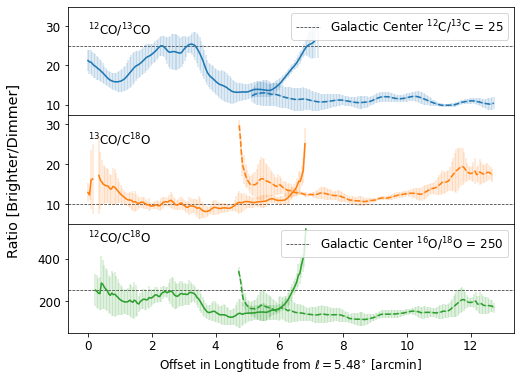

In [145]:
#plt.figure(figsize=(8,6),dpi=150)
#plt.rcParams.update({'font.size': 12})

fig, axs = plt.subplots(3, sharex=True, gridspec_kw={'hspace': 0})#, constrained_layout=True)

axs[0].errorbar(x_1729, mean_ratio_1729a, std_ratio_1729a, alpha = 0.2, color = 'tab:blue')
axs[0].errorbar(x_1729, mean_ratio_1729b, std_ratio_1729b, alpha = 0.2, color = 'tab:blue')
axs[1].errorbar(x_2931, mean_ratio_2931a, std_ratio_2931a, alpha = 0.2, color = 'tab:orange')
axs[1].errorbar(x_2931, mean_ratio_2931b, std_ratio_2931b, alpha = 0.2, color = 'tab:orange')
axs[2].errorbar(x_1731, mean_ratio_1731a, std_ratio_1731a, alpha = 0.2, color = 'tab:green')
axs[2].errorbar(x_1731, mean_ratio_1731b, std_ratio_1731b, alpha = 0.2, color = 'tab:green')

axs[0].plot(x_1729, mean_ratio_1729a, color = 'tab:blue')#, label='$^{12}$CO/$^{13}$CO')
axs[0].plot(x_1729, mean_ratio_1729b, color = 'tab:blue', linestyle='dashed')
axs[1].plot(x_2931, mean_ratio_2931a, color = 'tab:orange')#, label='$^{13}$CO/C$^{18}$O')
axs[1].plot(x_2931, mean_ratio_2931b, color = 'tab:orange', linestyle='dashed')
axs[2].plot(x_1731, mean_ratio_1731a, color = 'tab:green')#, label='$^{12}$CO/C$^{18}$O')
axs[2].plot(x_1731, mean_ratio_1731b, color = 'tab:green', linestyle='dashed')

#for ax in axs.flat:
#    ax.legend()
#    ax.label_outer()  
    
def inverse(x):
    """Vectorized 1/x, treating x==0 manually"""
    x = np.array(x).astype(float)
    near_zero = np.isclose(x, 0)
    x[near_zero] = np.inf
    x[~near_zero] = 1 / x[~near_zero]
    return x

axs[0].axhline(25, color='black', linestyle='dashed', alpha=0.8, zorder=-5, linewidth=0.75, label='Galactic Center $^{12}$C/$^{13}$C = 25') # 12/13
#axs[0].axhline(30, color='purple', linestyle='dashed', alpha=0.75, zorder=-5, linewidth=0.75)
#axs[0].axhline(40, color='red', linestyle='dashed', alpha=0.75, zorder=-5, linewidth=0.75)
axs[0].text(0, 28, '$^{12}$CO/$^{13}$CO')
axs[0].legend(loc='upper right')
axs[0].set_ylim(top=35)
#axs[0].axhline(77, color='red', linestyle='dotted') 

axs[1].axhline(250/25, color='black', linestyle='dashed', alpha=0.8, zorder=-5, linewidth=0.75) # 18/13
#axs[1].axhline(400/30, color='purple', linestyle='dashed', alpha=0.75, zorder=-5, linewidth=0.75)
#axs[1].axhline(200/40, color='red', linestyle='dashed', alpha=0.75, zorder=-5, linewidth=0.75)
#axs[1].axhline(25, color='purple', linestyle='dotted', alpha=0.75, zorder=-5, linewidth=0.75)
axs[1].text(0, 25, '$^{13}$CO/C$^{18}$O')
#axs[1].set_ylim(top=25)
#axs[1].axhline(500/90, color='red', linestyle='dotted') 

axs[2].axhline(250, color='black', linestyle='dashed', alpha=0.8, zorder=-5, linewidth=0.75, label='Galactic Center $^{16}$O/$^{18}$O = 250') # 12/18
#axs[2].axhline(400, color='purple', linestyle='dashed', alpha=0.75, zorder=-5, linewidth=0.75, label='Measured Maximum')
#axs[2].axhline(200, color='red', linestyle='dashed', alpha=0.75, zorder=-5, linewidth=0.75, label='Nuclei of galaxies')
#axs[2].axhline(1/490, color='red', linestyle='dotted') 
#axs[2].axhline(327, color='red', linestyle='dashed', alpha=0.75, zorder=-5, linewidth=0.75, label='4kpc ring') 
axs[2].text(0, 475, '$^{12}$CO/C$^{18}$O')
axs[2].legend(loc='upper right')
#axs[2].axhline(1/(327+32), color='red', linestyle='dashed') 
#axs[2].axhline(1/(327-32), color='red', linestyle='dashed') 

#secax0 = axs[0].secondary_yaxis('right',functions=(inverse, inverse))
#secax1 = axs[1].secondary_yaxis('right',functions=(inverse, inverse))
#secax2 = axs[2].secondary_yaxis('right',functions=(inverse, inverse))
    
plt.xlabel("Offset in Longtitude from $\ell=5.48^{\circ}$ [arcmin]", fontsize=12)
#fig.supylabel('Ratio [Dimmer/Brighter]', horizontalalignment='left')#, fontsize=16)
fig.supylabel('Ratio [Brighter/Dimmer]', horizontalalignment='left')#, fontsize=16)
#plt.ylabel('Ratio [Brighter/Dimmer]')
#plt.text(x=1, y=0.5, s='Ratio [Brighter/Dimmer]', rotation='vertical', transform=fig.transFigure, ha='right',va='center', fontsize=12)
#fig.supylabel('Ratio [Brighter/Dimmer]', x=1.01)#, horizontalalignment='center')

fig.set_figheight(6)
fig.set_figwidth(8)


#plt.savefig('/orange/adamginsburg/cmz/g5/code/plots/isotopologue_updated.pdf', bbox_inches='tight')

In [146]:
print(

SyntaxError: unexpected EOF while parsing (149104261.py, line 1)

### Opacity

In [ ]:
def funct(tau, A): # = R
    #A = 30
    return (1-np.e**(-tau))/(1-np.e**(-tau/A))

def F(tau, R=20, A=25):
    return R - funct(tau, A)

In [ ]:
taus_full = np.ones(np.nan_to_num(ratio_1729_full).shape)
rat_full = np.nan_to_num(ratio_1729_full)

for t in range(len(taus_full)):
    taus_full[t] = (fsolve(F, taus_full[t], rat_full[t]))*(rat_full[t] != 0)

In [ ]:
mom0_17_full = cube_17_full.with_mask(mask_17_full).spectral_slab(15*u.km/u.second, 200*u.km/u.second).moment0()

In [ ]:
coord = SkyCoord(5.413*u.deg, -22.35*u.arcmin, frame=Galactic)
coord.to_pixel(wcs=ratio_1729_full.wcs)

In [ ]:
pro4_full = Projection(value=taus_full, wcs=ratio_1729_full.wcs)
pro4_full[pro4_full<=0]=np.nan
pro4_full.quicklook()
pro4_full.FITSFigure.show_colorscale(cmap='plasma', vmin=0, vmax=5)
pro4_full.FITSFigure.show_contour(data=mom0_17_full.hdu)
#levs=pro4_full.FITSFigure.show_contour(data=pro4_full.hdu, returnlevels=True)
pro4_full.FITSFigure.show_markers(coord.to_pixel(wcs=ratio_1729_full.wcs)[0], coord.to_pixel(wcs=ratio_1729_full.wcs)[1], coords_frame='pixel', layer=True, c='none', edgecolor='k', s=1000)
pro4_full.FITSFigure.show_markers(coord.l, coord.b, marker='x', c='black', s=500)
pro4_full.FITSFigure.colorbar.set_axis_label_text('Opacity')

In [ ]:
taus_all = np.ones(np.nan_to_num(ratio_1729).shape)
rat_all = np.nan_to_num(ratio_1729)

for t in range(len(taus_all)):
    taus_all[t] = (fsolve(F, taus_all[t], rat_all[t]))*(rat_all[t] != 0)
    

In [ ]:
pro4 = Projection(value=taus_all, wcs=ratio_1729.wcs)
pro4[pro4<=0]=np.nan
pro4.quicklook()
pro4.FITSFigure.show_colorscale(cmap='plasma')
pro4.FITSFigure.colorbar.set_axis_label_text('Opacity')
#pro4.savefig('/orange/adamginsburg/cmz/g5/code/plots/opa1213.fits')
pro4.hdu.writeto('/orange/adamginsburg/cmz/g5/code/plots/opa1213.fits', overwrite=True)

In [ ]:
np.nanmean(pro4)

In [ ]:
np.nanmin(pro4)

In [ ]:
taus_a = np.ones(np.nan_to_num(ratio_1729a).shape)
rat_a = np.nan_to_num(ratio_1729a)

for t in range(len(taus_a)):
    taus_a[t] = (fsolve(F, taus_a[t], rat_a[t]))*(rat_a[t] != 0)
    

In [ ]:
pro4a = Projection(value=taus_a, wcs=ratio_1729a.wcs)
pro4a[pro4a<=0] = np.nan
pro4a.quicklook()
pro4a.FITSFigure.show_colorscale(cmap='plasma')
pro4a.FITSFigure.colorbar.set_axis_label_text('Opacity')

In [ ]:
np.nanmean(pro4a)

In [ ]:
np.nanmax(pro4a[pro4a<9])

In [ ]:
rat_1729b = ratio_1729b*1.0
rat_1729b[rat_1729b<0] = np.nan
rat_1729b[rat_1729b>40] = np.nan
taus_b = np.ones(np.nan_to_num(rat_1729b).shape)
rat_b = np.nan_to_num(rat_1729b)

for t in range(len(taus_b)):
    taus_b[t] = (fsolve(F, taus_b[t], rat_b[t]))*(rat_b[t] != 0)
    

In [ ]:
pro4b = Projection(value=taus_b, wcs=rat_1729b.wcs)
pro4b[pro4b<=0] = np.nan
pro4b.quicklook()
pro4b.FITSFigure.show_colorscale(cmap='plasma')
pro4b.FITSFigure.colorbar.set_axis_label_text('Opacity')

In [ ]:
np.nanmean(pro4b)

In [ ]:
np.nanmax(pro4b[pro4b<3.47])

In [ ]:
def F_1218(tau, R=200, A=250):
    return R - funct(tau, A)

In [ ]:
taus_alt_full = np.ones(np.nan_to_num(ratio_1731_full).shape)
rat_alt_full = np.nan_to_num(ratio_1731_full)

for t in range(len(taus_alt_full)):
    taus_alt_full[t] = (fsolve(F_1218, taus_alt_full[t], rat_alt_full[t]))*(rat_alt_full[t] != 0)

In [ ]:
pro4_alt_full = Projection(value=taus_alt_full, wcs=ratio_1731_full.wcs)
pro4_alt_full[pro4_alt_full==0] = np.nan
pro4_alt_full.quicklook()
pro4_alt_full.FITSFigure.show_colorscale(cmap='plasma', vmin=0, vmax=4)
pro4_alt_full.FITSFigure.show_markers(coord.to_pixel(wcs=ratio_1729_full.wcs)[0], coord.to_pixel(wcs=ratio_1729_full.wcs)[1], coords_frame='pixel', layer=True, c='none', edgecolor='k', s=1000)
pro4_alt_full.FITSFigure.show_markers(coord.l, coord.b, marker='x', c='black', s=500)
pro4_alt_full.FITSFigure.colorbar.set_axis_label_text('Opacity')

In [ ]:
pro4_full = Projection(value=taus_full, wcs=ratio_1729_full.wcs)
pro4_full[pro4_full<=0]=np.nan
pro4_full.quicklook()
pro4_full.FITSFigure.show_colorscale(cmap='plasma', vmin=0, vmax=4)
pro4_full.FITSFigure.show_contour(data=mom0_17_full.hdu)
#levs=pro4_full.FITSFigure.show_contour(data=pro4_full.hdu, returnlevels=True)
pro4_full.FITSFigure.show_markers(coord.to_pixel(wcs=ratio_1729_full.wcs)[0], coord.to_pixel(wcs=ratio_1729_full.wcs)[1], coords_frame='pixel', layer=True, c='none', edgecolor='k', s=1000)
pro4_full.FITSFigure.show_markers(coord.l, coord.b, marker='x', c='black', s=500)
pro4_full.FITSFigure.colorbar.set_axis_label_text('Opacity')

In [ ]:
print(

### Exploring Cubes

In [ ]:
velo = cube_17.spectral_axis # 50-100/125 km/s

In [ ]:
lat = cube_17.spatial_coordinate_map[0]

In [ ]:
long = cube_17.spatial_coordinate_map[1] # 5-8 arcmin

In [ ]:
np.max(long) - 5*u.arcmin

In [ ]:
np.max(long) - 8*u.arcmin

In [ ]:
ran_long = long[(long>(np.max(long) - 8.5*u.arcmin)) & (long< (np.max(long) - 4.5*u.arcmin))]

In [ ]:
ran_velo = velo[(velo > 50*u.km/u.second) & (velo < 100*u.km/u.second)]

In [ ]:
cube_17.mask

In [ ]:
#sub_cube = cube.subcube(xlo=5*u.deg, xhi=6*u.deg, 
#                            ylo=2*u.deg, yhi=2.1*u.deg, 
#                            zlo=50*u.GHz, zhi=51*u.GHz) 

In [ ]:
sub_cube = cube_17.subcube(xlo=np.max(long) - 9.5*u.arcmin, xhi=np.max(long) - 4*u.arcmin, zlo=15*u.km/u.second, zhi=200*u.km/u.second)

In [ ]:
sub_cube.moment0().quicklook()

In [ ]:
x = sub_cube.spatial_coordinate_map[1]
y = x[0].value*(10)/(np.max(x[0]).value-np.min(x[0]).value) + 50

In [ ]:
plt.plot(x[0], y)

In [ ]:
smom0 = sub_cube.moment0(axis=1)

In [ ]:
smom0.quicklook??

In [ ]:
sub_cube.longitude_extrema

In [ ]:
x[0]

In [ ]:
x_n = 5*u.deg + 23*u.arcmin
y_n = 100*u.m/u.second

In [ ]:
fig = pl.figure(figsize=(6,6))
ax = pl.subplot(111, projection=wcs.WCS(smom0.header))
im = ax.imshow(smom0.data)
ax0 = ax.coords[0]
ax0.set_format_unit(u.arcmin)
ax1 = ax.coords[1]
ax1.set_format_unit(u.km/u.s)
ax.set_ylabel("Velocity [km/s]")
#ax.set_xlabel("Offset in Longtit
ax.set_xlabel("Galactic Longitude")
ax.set_aspect(0.1)
#ax.scatter(x[0].to_pixel(), y, color='red')
#ax.scatter(50, 50, color='red')

In [ ]:
def get_y(x, p1x, p1y, p2x, p2y):
    return (p1y - p2y)/(p1x - p2x)*x + p1y - p1x*(p1y - p2y)/(p1x - p2x)

In [ ]:
x = np.arange(smom0.data.shape[1])
# y = (p1y - p2y)/(p1x - p2x)*x + p1y - p1x*(p1y - p2y)/(p1x - p2x)
y = (260 - 350)/(55 - 100)*x + 260 - 55*(260 - 350)/(55 - 100)
y_2 = x*(700-260)/(40-55) + 700-40*(700-260)/(40-55)
y_3 = get_y(x, 40, 600, 80, 880) #(700 - 900)/(40 - 65)*x + 700 - 40*(700 - 900)/(40 - 65)
p1 = (100, 350)
p2 = (65, 900)
y_4 = (350 - 900)/(100 - 65)*x + 350 - 100*(350 - 900)/(100 - 65)

In [ ]:
ax = pl.subplot(111)
ax.imshow((smom0).data)
#ax.imshow((smom0*trap).data)
ax.set_aspect(0.1)
plt.gca().invert_yaxis()
ax.plot(x, y  ) # (55,260), (100,350)
ax.plot(x, y_2) # (40,700), (55,260)
ax.plot(x, y_3) # (40,700), (65,900)
ax.plot(x, y_4) # (100,350), (65,900)
#ax.scatter(40, 700)
ax.scatter(55, 260)
ax.scatter(100, 350)
#ax.scatter(65, 900)

ax.scatter(40, 600)
ax.scatter(80, 880)
ax.set_ylim(top=smom0.data.shape[0], bottom=0)
ax.scatter(70, 500)

In [ ]:
def cross_product(xA, yA, x1, y1, x2, y2): 
    v1 = (x2-x1, y2-y1)   # Vector 1
    v2 = (x2-xA, y2-yA)   # Vector 2
    xp = v1[0]*v2[1] - v1[1]*v2[0]  # Cross product
    above = False
    if xp < 0:
        above = True
        #print('on one side')
    return above

In [ ]:
mask = smom0.mask.include()
xA = 70
yA = 500
cross_product(xA, yA,55,260,100,350) # y
cross_product(xA, yA,40,700,55,260) # y_2
not cross_product(xA, yA,40,700,65,900) # y_3
cross_product(xA, yA,100,350,65,900) # y_4

In [ ]:
trap = np.full(mask.shape, False)

for yA in range(trap.shape[0]):
    for xA in range(trap.shape[1]):
        check1 = cross_product(xA, yA,55,260,100,350)
        check2 = cross_product(xA, yA,40,700,55,260)
        #check3 = not cross_product(xA, yA,40,700,65,900)
        check3 = not cross_product(xA, yA,40, 600,80, 880)
        check4 = cross_product(xA, yA,100,350,65,900)
        trap[yA, xA] = check1 and check2 and check3 and check4

In [ ]:
ax = pl.subplot(111)
plt.imshow(mask)
ax.set_aspect(0.1)
plt.gca().invert_yaxis()
ax.plot(x, y)
ax.plot(x, y_2)
ax.plot(x, y_3)
ax.plot(x, y_4)
ax.set_ylim(top=smom0.data.shape[0], bottom=0)

In [ ]:
smom0.quicklook(use_aplpy=False, )
#plt.plot(x[0], y)

In [ ]:
#sub_cube.moment0(axis=1).quicklook()
#plt.plot(x[0], y)

In [ ]:
sub_cube.shape

In [ ]:
trap[:, None, :].shape

In [ ]:
sub_cube.with_mask(trap[:, None, :]).moment0().quicklook()

In [ ]:
sub_cube_29 = cube_29.reproject(cube_17.header).subcube(xlo=np.max(long) - 9.5*u.arcmin, xhi=np.max(long) - 4*u.arcmin, zlo=15*u.km/u.second, zhi=200*u.km/u.second)

In [ ]:
sub_cube_29.moment0(axis=1).quicklook()

In [ ]:
sub_cube_29.with_mask(trap[:, None, :]).moment0().quicklook()

In [ ]:
ratio_bridge = sub_cube.with_mask(trap[:, None, :]).moment0() / sub_cube_29.with_mask(trap[:, None, :]).moment0()
ratio_bridge[ratio_bridge<0] = np.nan
ratio_bridge[ratio_bridge>100] = np.nan
ratio_bridge.quicklook()

In [ ]:
taus_bridge = np.ones(np.nan_to_num(ratio_bridge).shape)
rat_bridge = np.nan_to_num(ratio_bridge)

for t in range(len(taus_bridge)):
    taus_bridge[t] = (fsolve(F, taus_bridge[t], rat_bridge[t]))*(rat_bridge[t] != 0)

In [ ]:
pro4_bridge = Projection(value=taus_bridge, wcs=ratio_bridge.wcs)
pro4_bridge[pro4_bridge==0] = np.nan
pro4_bridge.quicklook()
pro4_bridge.FITSFigure.show_colorscale(cmap='plasma')
pro4_bridge.FITSFigure.colorbar.set_axis_label_text('Opacity')